# Credit Card Fraud Detection


# The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

 It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In this notebook we use 2 different techniques how to tackle with highly unbalanced data. Oversampling and Undersampling

In [7]:
#Library

In [1]:
import pandas as pd
import numpy as np
np.random.seed(2019)

import time

import zipfile
import os
os.getcwd()

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, learning_curve
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.base import clone


from scikitplot.estimators import plot_learning_curve

import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances


from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

C:\Users\48500\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\48500\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', None)


In [3]:
df = pd.read_csv(r"creditcard.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [5]:
df.isnull().sum().any()

False

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
print('Percentage of fraud {}%'.format(round(df['Class'].value_counts(normalize=True)[1]*100,2)))

Percentage of fraud 0.17%


# Histogram - Amount

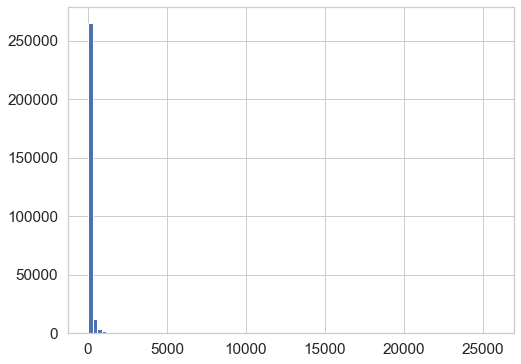

In [10]:
sns.set(font_scale=1.4, style="whitegrid")
plt.figure(figsize=(8,6))
df['Amount'].hist(bins=90)

# Histogram - Amount only Fraud transaction

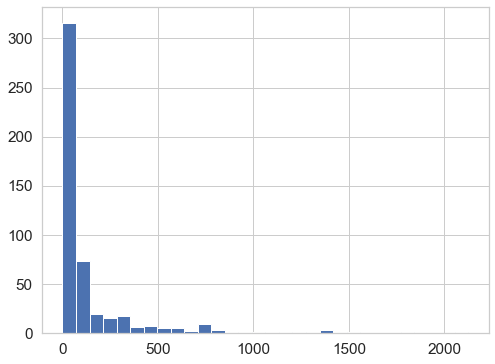

In [15]:
plt.figure(figsize=(8,6))
df[df.Class==1]['Amount'].hist(bins=30)

# Histogram - Amount only valid transaction

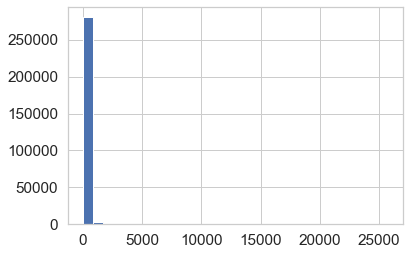

In [17]:
df[df.Class==0]['Amount'].hist(bins=30)

In [18]:
df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [21]:
for x in list(range(50,101,5)):
    print("Percentyle Amount valid {} : {}".format(x,round(np.percentile(df[df.Class==0]['Amount'],x))))

Percentyle Amount valid 50 : 22.0
Percentyle Amount valid 55 : 29.0
Percentyle Amount valid 60 : 37.0
Percentyle Amount valid 65 : 47.0
Percentyle Amount valid 70 : 60.0
Percentyle Amount valid 75 : 77.0
Percentyle Amount valid 80 : 100.0
Percentyle Amount valid 85 : 140.0
Percentyle Amount valid 90 : 203.0
Percentyle Amount valid 95 : 364.0
Percentyle Amount valid 100 : 25691.0


In [24]:
for x in list(range(50,101,5)):
    print("Percentyle Amount Fraud {} : {}".format(x,round(np.percentile(df[df.Class==1]['Amount'],x))))

Percentyle Amount Fraud 50 : 9.0
Percentyle Amount Fraud 55 : 20.0
Percentyle Amount Fraud 60 : 40.0
Percentyle Amount Fraud 65 : 78.0
Percentyle Amount Fraud 70 : 100.0
Percentyle Amount Fraud 75 : 106.0
Percentyle Amount Fraud 80 : 152.0
Percentyle Amount Fraud 85 : 250.0
Percentyle Amount Fraud 90 : 347.0
Percentyle Amount Fraud 95 : 641.0
Percentyle Amount Fraud 100 : 2126.0


# We remove 1% outliers to visualize

In [25]:
def histo(col, pd = 1, pg = 99):
        plt.figure(figsize=(6,4))
        sns.distplot(df[col][(df[col]  > np.percentile(df[col],pd)) & ((df[col] < np.percentile(df[col],pg)))],  kde=False)
        plt.title(col)
        plt.show()

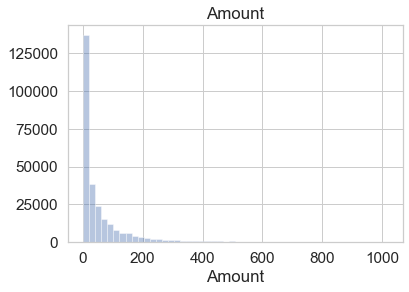

In [27]:
histo(col='Amount')

# Histogram  - Time 

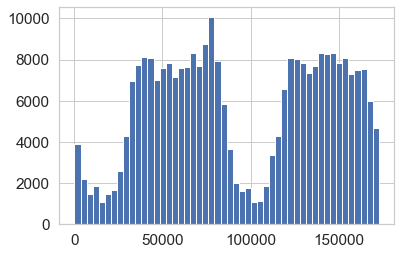

In [32]:
df['Time'].hist(bins=50)

# Histogram - Time only valid transaction

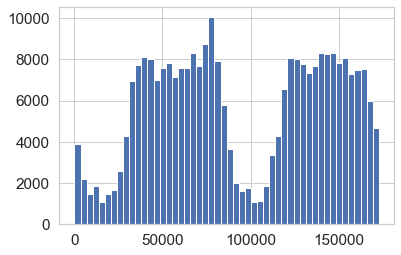

In [31]:
df[df.Class==0]['Time'].hist(bins=50)

# Histogram - Time only Fraud transaction. 
We can recognize 4 peaks. 

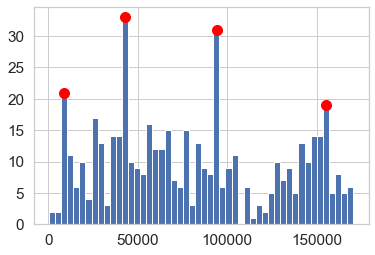

In [35]:
df[df.Class==1]['Time'].hist(bins=50);
plt.plot(43000,33, 'o', color = 'red', markersize = 10);
plt.plot(9000,21, 'o', color = 'red', markersize = 10);
plt.plot(94000,31, 'o', color = 'red', markersize = 10);
plt.plot(155000,19, 'o', color = 'red', markersize = 10);

# Graph of Time and Amount variable relationships.

<Figure size 3240x720 with 0 Axes>

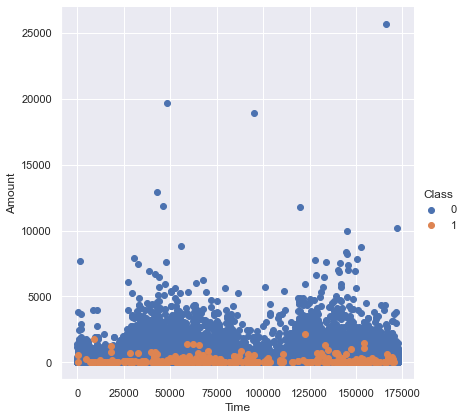

In [41]:
plt.figure(figsize=(45,10))
sns.FacetGrid(df, hue="Class", size = 6).map(plt.scatter, "Time", "Amount").add_legend()

# Histograms of all features

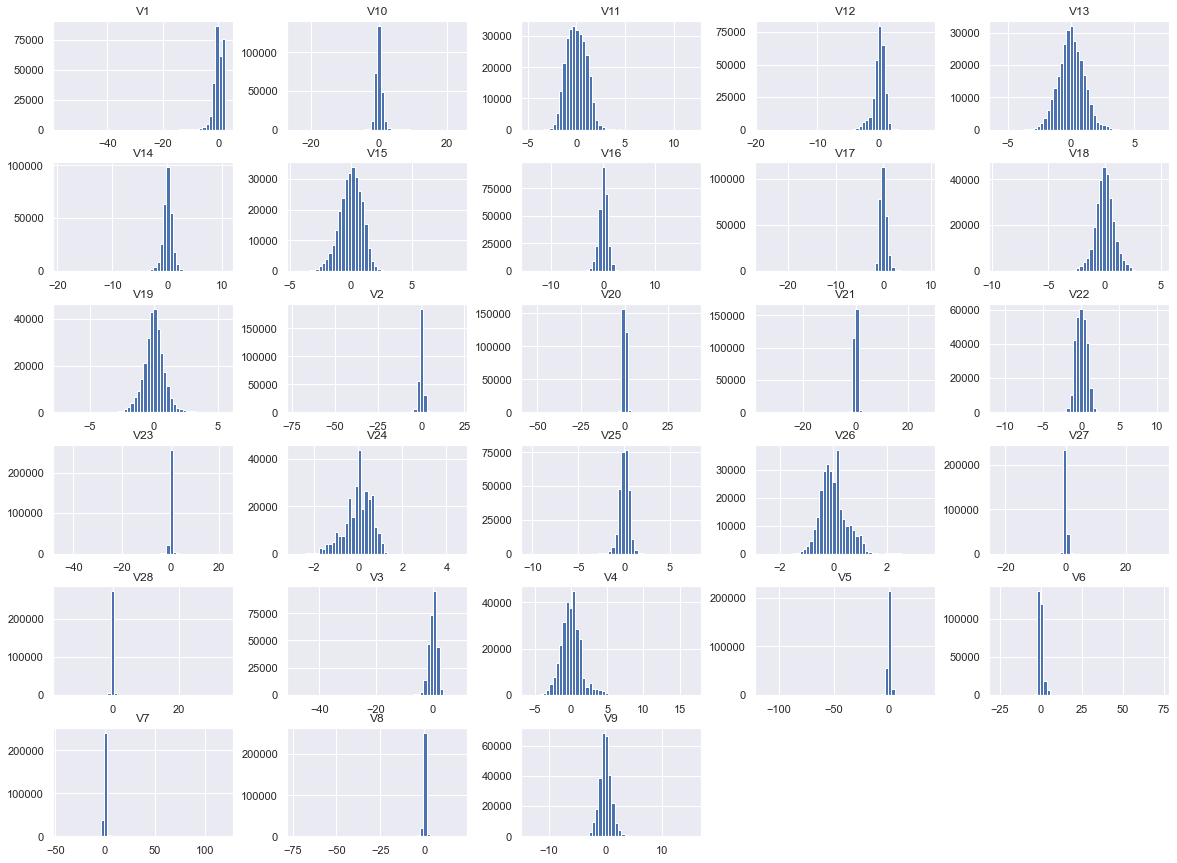

In [44]:
black = ['Amount','Class','Time']

col = [x for x in df.columns if x not in black]
df[col].hist(bins=50, figsize=(20,15))
plt.show()

# Histograms of all features after removing outliers

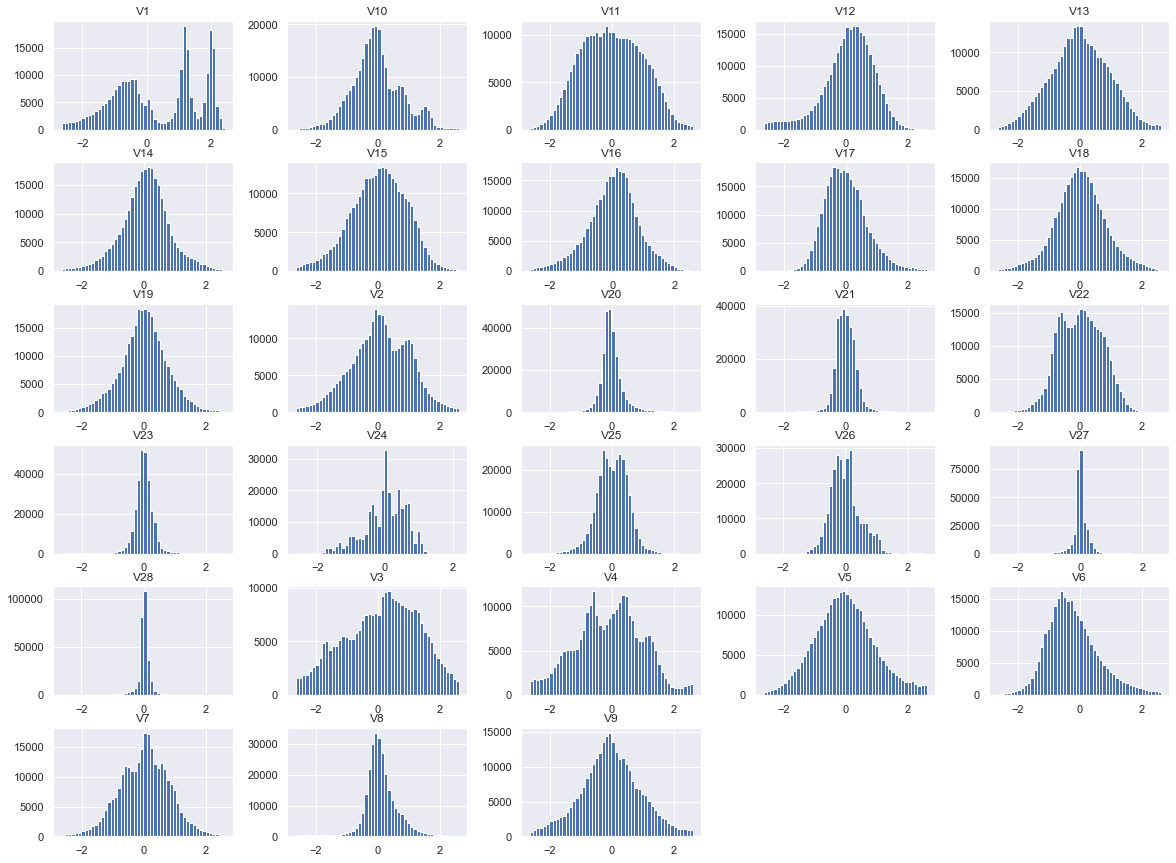

In [45]:
black = ['Amount','Class','Time']
x = [x for x in df.columns if x not in black]
df[x][(df[x]  > np.percentile(df[x],1)) & ((df[x] < np.percentile(df[x],99)))].hist(bins=50, figsize=(20,15))
plt.show()

In [9]:
def plot_precision_vs_recall(precisions, recalls):    
    plt.plot(recalls, precisions, "b-", linewidth=2)    
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)   
    plt.axis([0, 1, 0, 1])

In [10]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):   
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)    
    plt.xlabel("Threshold", fontsize=12)
    plt.legend(loc="down right", fontsize=10)

In [11]:
def plot_roc_curve(fpr, tpr, label=None):     
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')   
    plt.axis([0, 1, 0, 1])    
    plt.xlabel('False positive rate', fontsize=13)
    plt.ylabel('True positive rate', fontsize=13)

In [12]:
def undersampling(X,y,n = 1):
    
    data = pd.concat([X,y], axis=1)
    Fraud_number = len(data[data.Class==1])

    Fraud_index = np.array(data[data.Class==1].index)
    No_Fraud_index = np.array(data[data.Class==0].index)
    
    Random_no_fraud_index = np.array(np.random.choice(No_Fraud_index, Fraud_number * n, replace = False))
    Index = np.concatenate([Fraud_index,Random_no_fraud_index ])

    Undersampling_data = data.loc[Index]
    y_undersampling =  Undersampling_data['Class']
    X_undersampling = Undersampling_data.drop("Class", axis = 1)
    
    return X_undersampling, y_undersampling

In [13]:
def e5(model, X,y,X_t,y_t):
    model1 = model.fit(X, y)
    perm = PermutationImportance(model1).fit(X_t, y_t)
    return eli5.show_weights(perm, top=30)

In [14]:
def draw_importance(importances):
    d = { 'Cecha' : X_tr.columns, 
        'importance' :importances}
    importance = pd.DataFrame(d)
    importance = importance.sort_values(by = "importance", ascending = False)
    importance = importance.iloc[:10]
    sns.set(font_scale=1.4, style="whitegrid")
    plt.show()
    return sns.barplot(x = "importance" , y ="Cecha",data =  importance, color= "#eb6c6a", )
   

# Splitting
`

In [20]:
X_tr = df.loc[:, df.columns!='Class']
y_tr = df.loc[:,'Class']

# Function for spliting and evaluationg model using different techniques. 
Method = noraml / undersampling / oversamping

# Success matrics = F1_Score

In [16]:
def split_and_train(model, method, splits=2, X=X_tr, y=y_tr, plot_LR = True, ROC = True, plot_PR2 = True):
    start = time.time()
    print("#################################################################################################")

    
    #### StratifiedKFold
    
    cv = StratifiedKFold(n_splits=splits, random_state=2020, shuffle=True)
    first_line = np.array([0,0])
    second_line = np.array([0,0])
    importances_all = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    scores = []
    scores_train = []
    scores_r = []
    scores_r_train = []
    scores_p = []
    scores_p_train = []
    scores_f = []
    scores_f_train = []
####################################################################
    if method == 'normal' :
        for train_idx, test_idx in cv.split(X,y):
            
            model.fit(X.loc[train_idx], y.loc[train_idx])
            y_pred = model.predict(X.loc[test_idx])
            y_pred_train = model.predict(X.loc[train_idx])
            
            
            X_tr = X.loc[train_idx]
            y_tr = y.loc[train_idx]
            X_t = X.loc[test_idx]
            y_t = y.loc[test_idx]


            
            scores_auc = round(roc_auc_score(y_t, y_pred ),3)
            scores_auc_train = round(roc_auc_score(y_tr, y_pred_train ),3)
            score1 = round(recall_score(y_t, y_pred),3)
            score1_train = round(recall_score(y_tr, y_pred_train),3)
            score2 = round(precision_score(y_t, y_pred),3)
            score2_train = round(precision_score(y_tr, y_pred_train),3)
            score3 = round(f1_score(y_t, y_pred),3)
            score3_train = round(f1_score(y_tr, y_pred_train),3)
            
            scores.append(scores_auc)
            scores_train.append(scores_auc_train)
            scores_r.append(score1)
            scores_r_train.append(score1_train)
            scores_p.append(score2)
            scores_p_train.append(score2_train)
            scores_f.append(score3)
            scores_f_train.append(score3_train)
            
            #########################################
            first, second = confusion_matrix(y_t, y_pred)
            first_line = first_line + first
            second_line = second_line + second
            #############################################d
            importances = model.feature_importances_
            importances_all = importances_all + importances
            
        if plot_LR == True:
            plot_learning_curve(model, X.loc[train_idx], y.loc[train_idx], cv = splits, scoring= 'f1', random_state=2020)

            
        #importance = e5(model,X.loc[train_idx], y.loc[train_idx],X_t , y_t)
        #importances = model.feature_importances_
        draw_importance(importances_all/3) 
            
            
        print("       AUC test: {}".format(scores))
        print("      AUC train: {}".format(scores_train))
        print("_"*50)
        print("    Recall test: {}".format(scores_r))
        print("   Recall train: {}".format(scores_r_train))
        print("_"*50)
        print("Precision test : {}".format(scores_p))
        print("Precision train: {}".format(scores_p_train))
        print("_"*50)
        print("       F1 test : {}".format(scores_f))
        print("       F1 Train: {}".format(scores_f_train))
        
    
        cm = np.array([first_line,second_line])
        print(cm)
####################################################################


    if method == 'undersampling':
        for train_idx, test_idx in cv.split(X, y):      
            X_tr = X.loc[train_idx]
            y_tr = y.loc[train_idx]
            X_t = X.loc[test_idx]
            y_t = y.loc[test_idx]
            
            

            X_undersampling, y_undersampling =  undersampling(X_tr, y_tr)       
            print(Counter(y_undersampling))
            #### Trening na undersampling
            model.fit(X_undersampling, y_undersampling)
            #### Predykcja dla full data
            y_pred = model.predict(X_t)
            y_pred_train = model.predict(X_undersampling)
            

          
            
            scores_auc = round(roc_auc_score(y_t, y_pred ),3)
            scores_auc_train = round(roc_auc_score(y_undersampling, y_pred_train ),3)
            score1 = round(recall_score(y_t, y_pred),3)
            score1_train = round(recall_score(y_undersampling, y_pred_train),3)
            score2 = round(precision_score(y_t, y_pred),3)
            score2_train = round(precision_score(y_undersampling, y_pred_train),3)
            score3 = round(f1_score(y_t, y_pred),3)
            score3_train = round(f1_score(y_undersampling, y_pred_train),3)
            
            scores.append(scores_auc)
            scores_train.append(scores_auc_train)
            scores_r.append(score1)
            scores_r_train.append(score1_train)
            scores_p.append(score2)
            scores_p_train.append(score2_train)
            scores_f.append(score3)
            scores_f_train.append(score3_train)
            
            #########################################
            first, second = confusion_matrix(y_t, y_pred)
            first_line = first_line + first
            second_line = second_line + second
            #############################################
            importances = model.feature_importances_
            importances_all = importances_all + importances
            
        if plot_LR == True:
            plot_learning_curve(model, X_undersampling, y_undersampling, cv = splits,scoring= 'f1', random_state=2020)
            
            
        #importance = e5(model,X_undersampling, y_undersampling,X_t,y_t)
        #importances = model.feature_importances_
        draw_importance(importances_all/3) 
        
        print("      AUC: {}".format(scores))
        print("   Recall: {}".format(scores_r))
        print("Precision: {}".format(scores_p))
        print("       F1: {}".format(scores_f))

        cm = np.array([first_line,second_line])
        print(cm)
        
####################################################################

    if method == 'oversampling':
        for train_idx, test_idx in cv.split(X, y):      
            X_tr = X.loc[train_idx]
            y_tr = y.loc[train_idx]
            X_t = X.loc[test_idx]
            y_t = y.loc[test_idx]
            
            smote = SMOTE(random_state=2019, sampling_strategy='minority')
            X_oversampling, y_oversampling =  smote.fit_sample(X_tr, y_tr)       
            print(Counter(y_oversampling))
            
            #### Trening na oversampling
            model.fit(X_oversampling, y_oversampling)
            #### Predykcja dla full data
            y_pred = model.predict(X_t)
            y_pred_train = model.predict(X_oversampling)
            
            print(Counter(y_pred))
            scores_auc = round(roc_auc_score(y_t, y_pred ),3)
            scores_auc_train = round(roc_auc_score(y_oversampling, y_pred_train ),3)
            score1 = round(recall_score(y_t, y_pred),3)
            score1_train = round(recall_score(y_oversampling, y_pred_train),3)
            score2 = round(precision_score(y_t, y_pred),3)
            score2_train = round(precision_score(y_oversampling, y_pred_train),3)
            score3 = round(f1_score(y_t, y_pred),3)
            score3_train = round(f1_score(y_oversampling, y_pred_train),3)
            
            scores.append(scores_auc)
            scores_train.append(scores_auc_train)
            scores_r.append(score1)
            scores_r_train.append(score1_train)
            scores_p.append(score2)
            scores_p_train.append(score2_train)
            scores_f.append(score3)
            scores_f_train.append(score3_train)
            
            #########################################
            first, second = confusion_matrix(y_t, y_pred)
            first_line = first_line + first
            second_line = second_line + second
            #############################################
            importances = model.feature_importances_
            importances_all = importances_all + importances

            
        if plot_LR == True:
            plot_learning_curve(model, X_oversampling, y_oversampling, cv = splits, scoring= 'f1', random_state=2020)
        #importance = e5(model,X.loc[train_idx], y.loc[train_idx],X_t , y_t)
        #importances = model.feature_importances_
        draw_importance(importances_all/3) 
        
        print("      AUC: {}".format(scores))
        print("   Recall: {}".format(scores_r))
        print("Precision: {}".format(scores_p))
        print("       F1: {}".format(scores_f))

        cm = np.array([first_line,second_line])
        print(cm)

  ####################################################################
            
    if ROC == True:
        
        fpr, tpr, thresholds = roc_curve(y_t, y_pred) 
    
        plt.figure(figsize=(6, 4))
        print('roc auc score: {}%'.format(round(roc_auc_score(y_t, y_pred)*100,2)))    
        plot_roc_curve(fpr, tpr)
        plt.show()
    
    if plot_PR2 == True:
        precisions, recalls,thresholds = precision_recall_curve(y_t, y_pred) 
        plt.figure(figsize=(6, 4))
        plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
        plt.show()
    
    
    
    print("#################################################################################################")
    end = time.time()

    print("Raport")
    print("_____________________________________")
    print("Method : {}".format(method))
    print("Model : {}".format(model))
    
#     print("      AUC test:  {}".format(round(np.mean(scores),2)))
#     print("     AUC train:  {}".format(round(np.mean(scores_train),2)))
    
#     print("   Recall test:  {}".format(round(np.mean(scores_r),2)))
#     print(" Recall train:   {}".format(round(np.mean(scores_r_train),2)))
    
#     print("Precision test:  {}".format(round(np.mean(scores_p),2)))
#     print("Precision train: {}".format(round(np.mean(scores_p_train),2)))
    
#     print("       F1 test:  {}".format(round(np.mean(scores_f),2)))
#     print("       F1 train: {}".format(round(np.mean(scores_f_train),2)))
    
    d = {'_':["AUC", "Recall", "Precision", "F1"] , 
         'Train': [round(np.mean(scores_train),2),round(np.mean(scores_r_train),2),
                   round(np.mean(scores_p_train),2),round(np.mean(scores_f_train),2)],
         "Test" : [round(np.mean(scores),2),round(np.mean(scores_r),2),
                   round(np.mean(scores_p),2),round(np.mean(scores_f),2)]}
    
    
    df = pd.DataFrame(data=d)
    print(df)
    
    print("Czas wykonania: {} sek".format(  round((end - start)/60),2))
    return 

# Decision Tree normal method

#################################################################################################


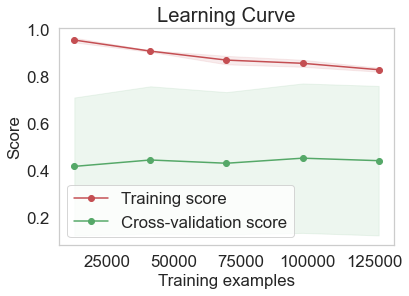

       AUC test: [0.875, 0.863, 0.854]
      AUC train: [0.849, 0.87, 0.892]
__________________________________________________
    Recall test: [0.75, 0.726, 0.707]
   Recall train: [0.698, 0.741, 0.784]
__________________________________________________
Precision test : [0.879, 0.793, 0.853]
Precision train: [0.877, 0.874, 0.824]
__________________________________________________
       F1 test : [0.809, 0.758, 0.773]
       F1 Train: [0.778, 0.802, 0.803]
[[284247     68]
 [   134    358]]
roc auc score: 85.36%


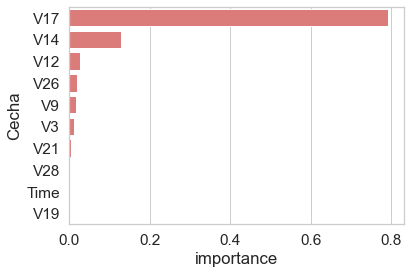

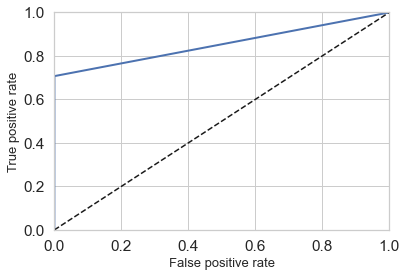

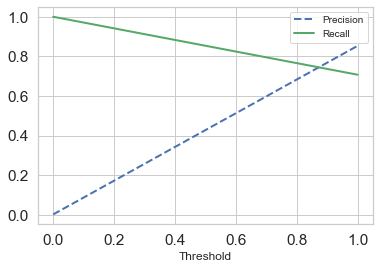

#################################################################################################
Raport
_____________________________________
Method : normal
Model : DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
           _  Train  Test
0        AUC   0.87  0.86
1     Recall   0.74  0.73
2  Precision   0.86  0.84
3         F1   0.79  0.78
Czas wykonania: 0 sek
Wall time: 24.1 s


In [35]:
%%time
split_and_train(DecisionTreeClassifier(max_depth=3, random_state=2020),method="normal",splits =3)

#################################################################################################


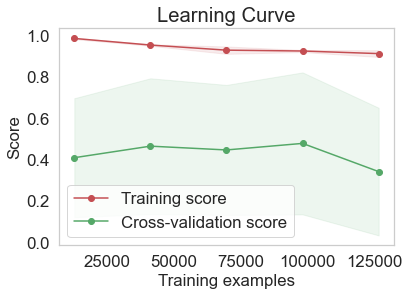

       AUC test: [0.902, 0.911, 0.841]
      AUC train: [0.899, 0.908, 0.918]
__________________________________________________
    Recall test: [0.805, 0.823, 0.683]
   Recall train: [0.799, 0.817, 0.835]
__________________________________________________
Precision test : [0.863, 0.849, 0.966]
Precision train: [0.923, 0.944, 0.938]
__________________________________________________
       F1 test : [0.833, 0.836, 0.8]
       F1 Train: [0.856, 0.876, 0.884]
[[284266     49]
 [   113    379]]
roc auc score: 84.14%


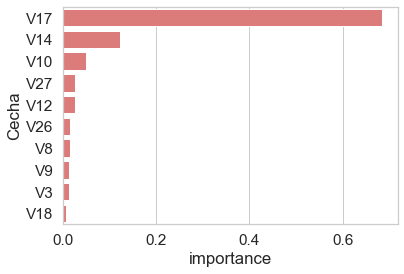

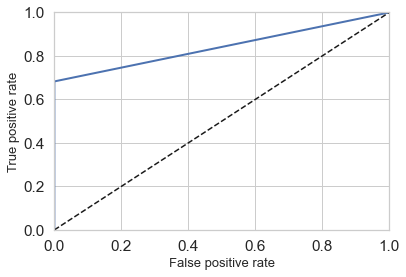

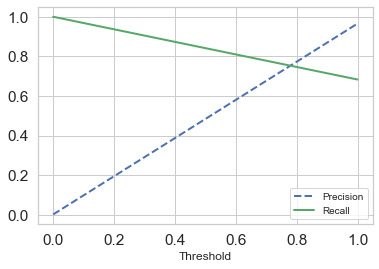

#################################################################################################
Raport
_____________________________________
Method : normal
Model : DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
           _  Train  Test
0        AUC   0.91  0.88
1     Recall   0.82  0.77
2  Precision   0.94  0.89
3         F1   0.87  0.82
Czas wykonania: 1 sek
Wall time: 43 s


In [36]:
%%time
split_and_train(DecisionTreeClassifier(max_depth=5,random_state=2020),method="normal",splits =3)

#################################################################################################


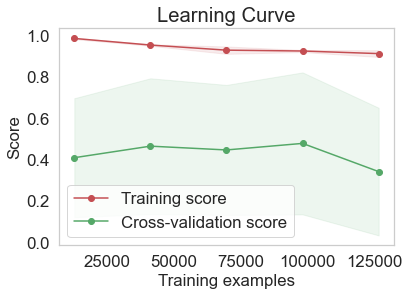

       AUC test: [0.902, 0.911, 0.841]
      AUC train: [0.899, 0.908, 0.918]
__________________________________________________
    Recall test: [0.805, 0.823, 0.683]
   Recall train: [0.799, 0.817, 0.835]
__________________________________________________
Precision test : [0.863, 0.849, 0.966]
Precision train: [0.923, 0.944, 0.938]
__________________________________________________
       F1 test : [0.833, 0.836, 0.8]
       F1 Train: [0.856, 0.876, 0.884]
[[284266     49]
 [   113    379]]
roc auc score: 84.14%


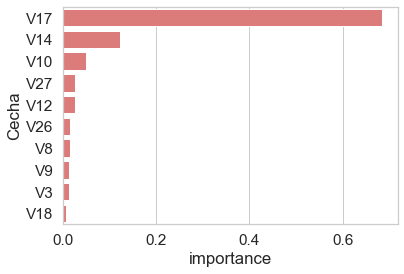

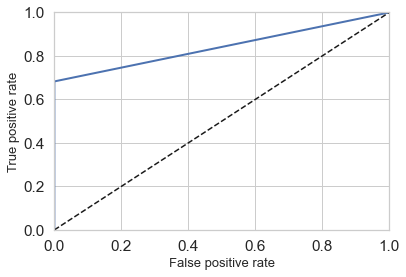

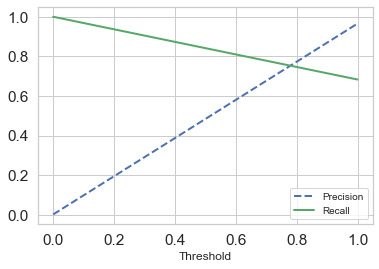

#################################################################################################
Raport
_____________________________________
Method : normal
Model : DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
           _  Train  Test
0        AUC   0.91  0.88
1     Recall   0.82  0.77
2  Precision   0.94  0.89
3         F1   0.87  0.82
Czas wykonania: 1 sek
Wall time: 43.4 s


In [37]:
%%time
split_and_train(DecisionTreeClassifier(max_depth=5,random_state=2020),method="normal",splits =3)

#################################################################################################


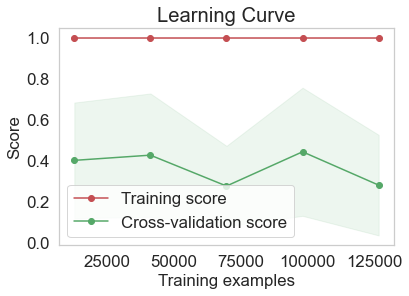

       AUC test: [0.887, 0.896, 0.838]
      AUC train: [1.0, 1.0, 1.0]
__________________________________________________
    Recall test: [0.774, 0.793, 0.677]
   Recall train: [1.0, 1.0, 1.0]
__________________________________________________
Precision test : [0.747, 0.765, 0.782]
Precision train: [1.0, 1.0, 1.0]
__________________________________________________
       F1 test : [0.76, 0.778, 0.725]
       F1 Train: [1.0, 1.0, 1.0]
[[284201    114]
 [   124    368]]
roc auc score: 83.83%


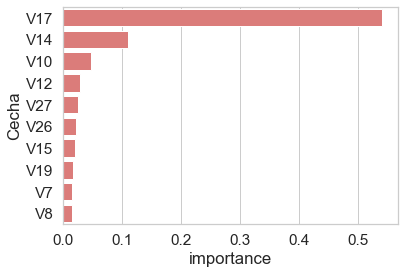

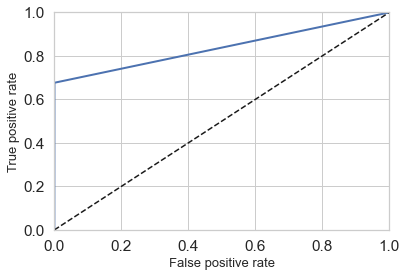

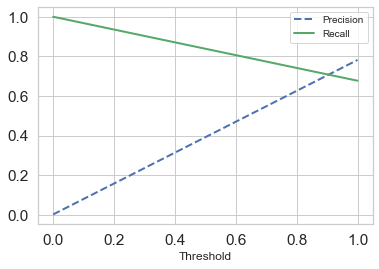

#################################################################################################
Raport
_____________________________________
Method : normal
Model : DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
           _  Train  Test
0        AUC    1.0  0.87
1     Recall    1.0  0.75
2  Precision    1.0  0.76
3         F1    1.0  0.75
Czas wykonania: 2 sek
Wall time: 2min 10s


In [38]:
%%time
split_and_train(DecisionTreeClassifier(random_state=2020),method="normal",splits =3)

# Decision Tree undersampling

#################################################################################################
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})


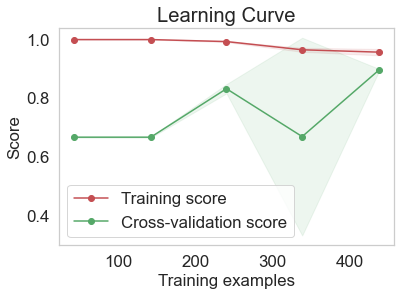

      AUC: [0.931, 0.931, 0.912]
   Recall: [0.915, 0.921, 0.884]
Precision: [0.029, 0.027, 0.025]
       F1: [0.056, 0.052, 0.049]
[[268147  16168]
 [    46    446]]
roc auc score: 91.23%


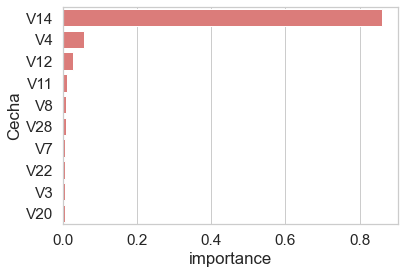

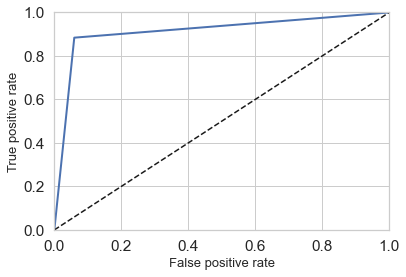

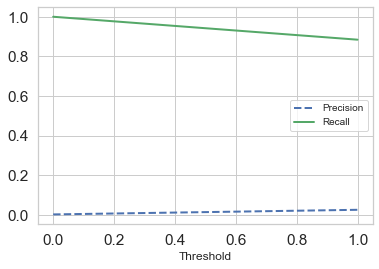

#################################################################################################
Raport
_____________________________________
Method : undersampling
Model : DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
           _  Train  Test
0        AUC   0.95  0.92
1     Recall   0.93  0.91
2  Precision   0.97  0.03
3         F1   0.95  0.05
Czas wykonania: 0 sek
Wall time: 2.27 s


In [30]:
%%time
split_and_train(DecisionTreeClassifier(max_depth=3,random_state=2020),method="undersampling",splits =3)


#################################################################################################
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})


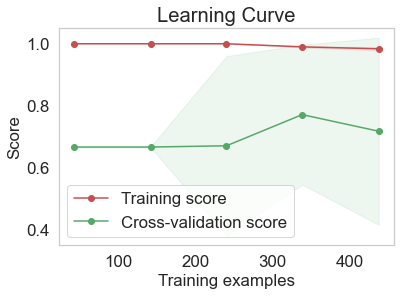

      AUC: [0.914, 0.884, 0.913]
   Recall: [0.902, 0.902, 0.915]
Precision: [0.02, 0.012, 0.018]
       F1: [0.04, 0.023, 0.035]
[[256217  28098]
 [    46    446]]
roc auc score: 91.35%


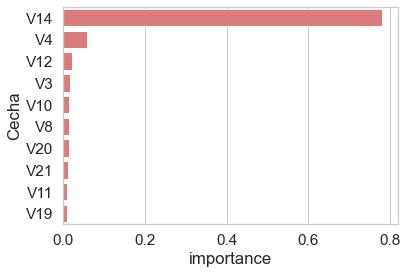

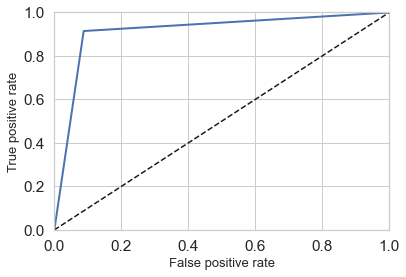

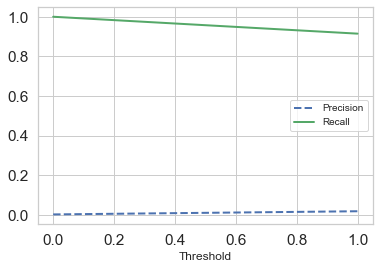

#################################################################################################
Raport
_____________________________________
Method : undersampling
Model : DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
           _  Train  Test
0        AUC   0.97  0.90
1     Recall   0.96  0.91
2  Precision   0.98  0.02
3         F1   0.97  0.03
Czas wykonania: 0 sek
Wall time: 2.45 s


In [31]:
%%time
split_and_train(DecisionTreeClassifier(max_depth=5,random_state=2020),method="undersampling",splits =3)


#################################################################################################
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})


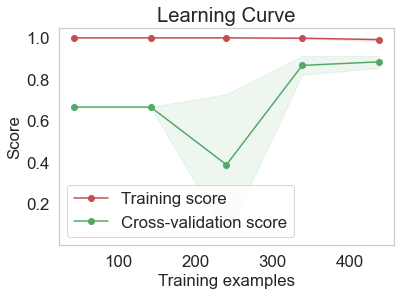

      AUC: [0.923, 0.915, 0.907]
   Recall: [0.915, 0.933, 0.896]
Precision: [0.022, 0.015, 0.019]
       F1: [0.044, 0.03, 0.036]
[[260270  24045]
 [    42    450]]
roc auc score: 90.72%


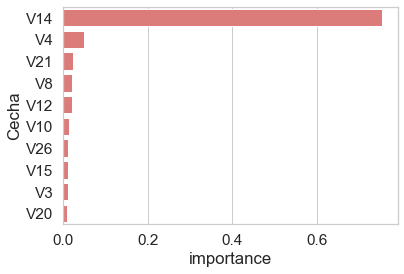

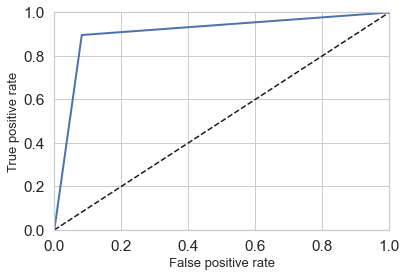

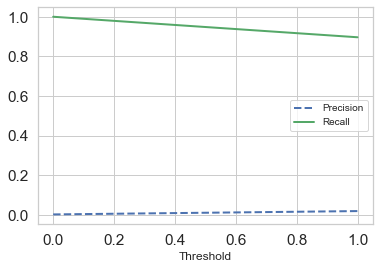

#################################################################################################
Raport
_____________________________________
Method : undersampling
Model : DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
           _  Train  Test
0        AUC   0.99  0.92
1     Recall   0.98  0.91
2  Precision   1.00  0.02
3         F1   0.99  0.04
Czas wykonania: 0 sek
Wall time: 2.25 s


In [32]:
%%time
split_and_train(DecisionTreeClassifier(max_depth=8,random_state=2020),method="undersampling",splits =3)


#################################################################################################
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})


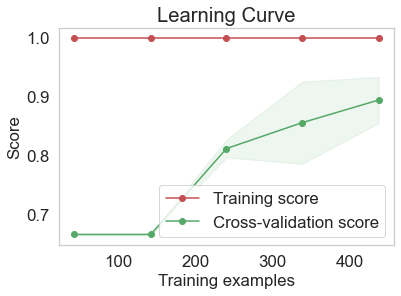

      AUC: [0.897, 0.91, 0.895]
   Recall: [0.902, 0.933, 0.866]
Precision: [0.014, 0.014, 0.019]
       F1: [0.028, 0.028, 0.038]
[[256086  28229]
 [    49    443]]
roc auc score: 89.48%


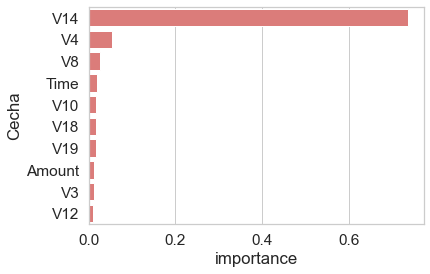

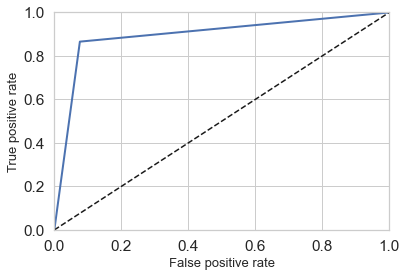

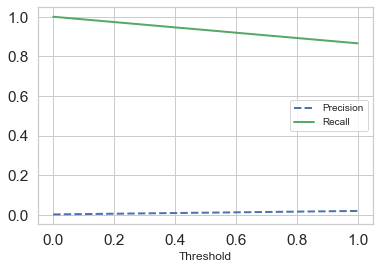

#################################################################################################
Raport
_____________________________________
Method : undersampling
Model : DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
           _  Train  Test
0        AUC    1.0  0.90
1     Recall    1.0  0.90
2  Precision    1.0  0.02
3         F1    1.0  0.03
Czas wykonania: 0 sek
Wall time: 2.48 s


In [33]:
%%time
split_and_train(DecisionTreeClassifier(random_state=2020),method="undersampling",splits =3)


#################################################################################################
Counter({0: 189543, 1: 189543})
Counter({0: 93520, 1: 1416})
Counter({0: 189543, 1: 189543})
Counter({0: 94199, 1: 737})
Counter({0: 189544, 1: 189544})
Counter({0: 93816, 1: 1119})


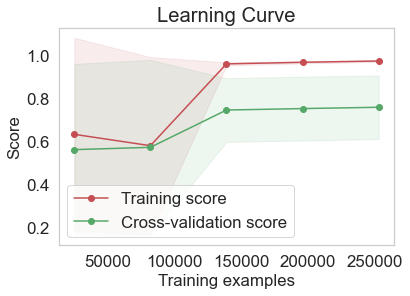

      AUC: [0.929, 0.945, 0.906]
   Recall: [0.872, 0.896, 0.823]
Precision: [0.101, 0.199, 0.121]
       F1: [0.181, 0.326, 0.21]
[[281468   2847]
 [    67    425]]
roc auc score: 90.64%


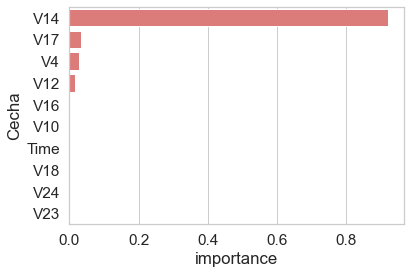

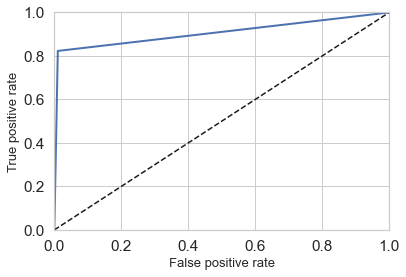

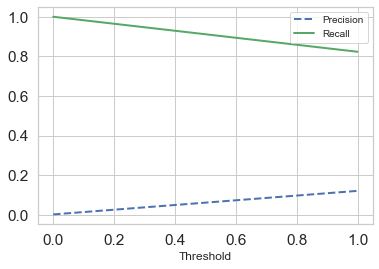

#################################################################################################
Raport
_____________________________________
Method : oversampling
Model : DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
           _  Train  Test
0        AUC   0.96  0.93
1     Recall   0.93  0.86
2  Precision   0.99  0.14
3         F1   0.96  0.24
Czas wykonania: 1 sek
Wall time: 51.6 s


In [34]:
%%time
split_and_train(DecisionTreeClassifier(max_depth=3, random_state=2020),method="oversampling",splits =3)

#################################################################################################
Counter({0: 189543, 1: 189543})
Counter({0: 93383, 1: 1553})
Counter({0: 189543, 1: 189543})
Counter({0: 93458, 1: 1478})
Counter({0: 189544, 1: 189544})
Counter({0: 93283, 1: 1652})


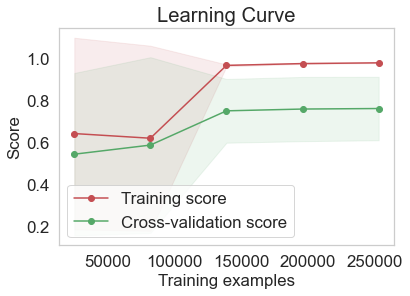

      AUC: [0.929, 0.941, 0.91]
   Recall: [0.872, 0.896, 0.835]
Precision: [0.092, 0.099, 0.083]
       F1: [0.167, 0.179, 0.151]
[[280059   4256]
 [    65    427]]
roc auc score: 90.97%


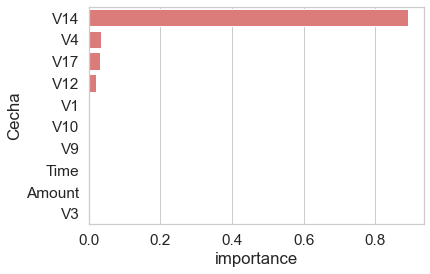

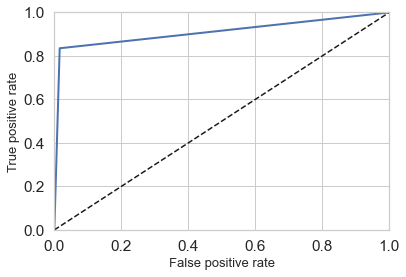

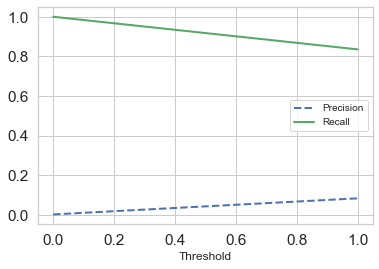

#################################################################################################
Raport
_____________________________________
Method : oversampling
Model : DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
           _  Train  Test
0        AUC   0.97  0.93
1     Recall   0.96  0.87
2  Precision   0.99  0.09
3         F1   0.97  0.17
Czas wykonania: 1 sek
Wall time: 1min 13s


In [39]:
%%time
split_and_train(DecisionTreeClassifier(max_depth=5, random_state=2020),method="oversampling",splits =3)

#################################################################################################
Counter({0: 189543, 1: 189543})
Counter({0: 93358, 1: 1578})
Counter({0: 189543, 1: 189543})
Counter({0: 93279, 1: 1657})
Counter({0: 189544, 1: 189544})
Counter({0: 93839, 1: 1096})


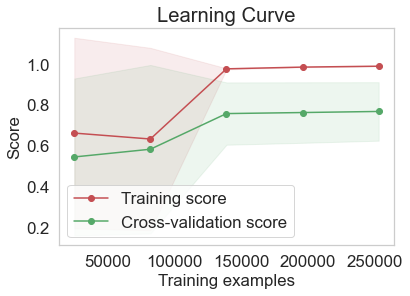

      AUC: [0.925, 0.937, 0.903]
   Recall: [0.866, 0.89, 0.817]
Precision: [0.09, 0.088, 0.122]
       F1: [0.163, 0.16, 0.213]
[[280406   3909]
 [    70    422]]
roc auc score: 90.35%


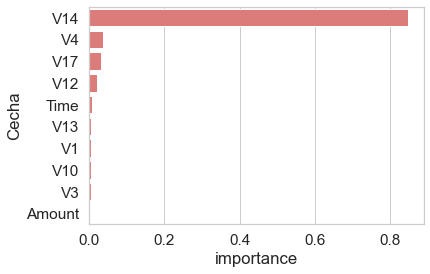

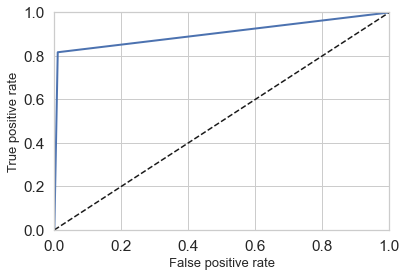

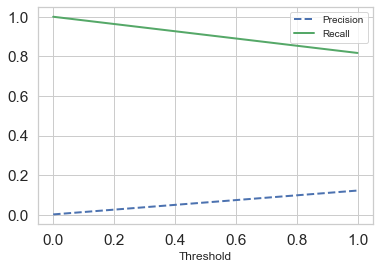

#################################################################################################
Raport
_____________________________________
Method : oversampling
Model : DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
           _  Train  Test
0        AUC   0.99  0.92
1     Recall   0.99  0.86
2  Precision   0.99  0.10
3         F1   0.99  0.18
Czas wykonania: 2 sek
Wall time: 1min 51s


In [40]:
%%time
split_and_train(DecisionTreeClassifier(max_depth=8, random_state=2020),method="oversampling",splits =3)

#################################################################################################
Counter({0: 189543, 1: 189543})
Counter({0: 94615, 1: 321})
Counter({0: 189543, 1: 189543})
Counter({0: 94627, 1: 309})
Counter({0: 189544, 1: 189544})
Counter({0: 94663, 1: 272})


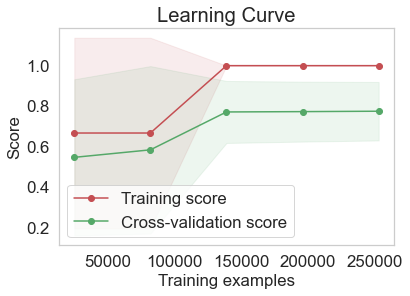

      AUC: [0.883, 0.911, 0.883]
   Recall: [0.768, 0.823, 0.768]
Precision: [0.393, 0.437, 0.463]
       F1: [0.52, 0.571, 0.578]
[[283800    515]
 [   105    387]]
roc auc score: 88.34%


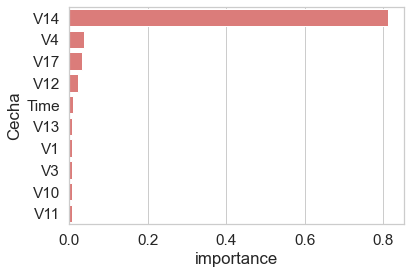

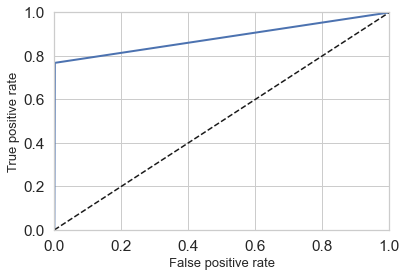

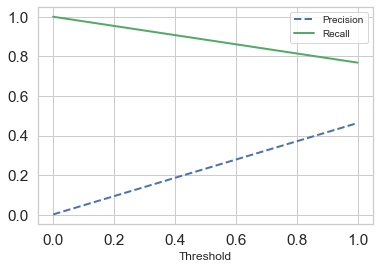

#################################################################################################
Raport
_____________________________________
Method : oversampling
Model : DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
           _  Train  Test
0        AUC    1.0  0.89
1     Recall    1.0  0.79
2  Precision    1.0  0.43
3         F1    1.0  0.56
Czas wykonania: 4 sek
Wall time: 3min 52s


In [41]:
%%time
split_and_train(DecisionTreeClassifier(random_state=2020),method="oversampling",splits =3)

# Random Forest normal method

#################################################################################################


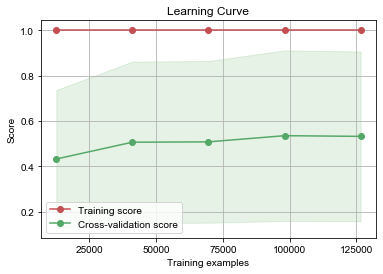

       AUC test: [0.908, 0.893, 0.863]
      AUC train: [1.0, 1.0, 1.0]
__________________________________________________
    Recall test: [0.817, 0.787, 0.726]
   Recall train: [1.0, 1.0, 1.0]
__________________________________________________
Precision test : [0.937, 0.902, 0.967]
Precision train: [1.0, 1.0, 1.0]
__________________________________________________
       F1 test : [0.873, 0.84, 0.829]
       F1 Train: [1.0, 1.0, 1.0]
[[284288     27]
 [   110    382]]
roc auc score: 86.28%


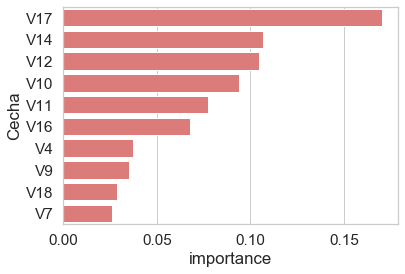

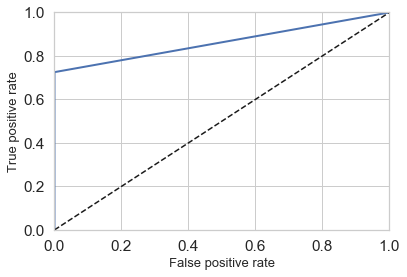

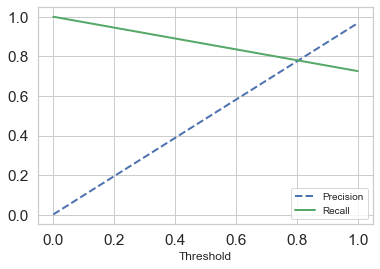

#################################################################################################
Raport
_____________________________________
Method : normal
Model : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2020,
                       verbose=0, warm_start=False)
           _  Train  Test
0        AUC    1.0  0.89
1     Recall    1.0  0.78
2  Precision    1.0  0.94
3         F1    1.0  0.85
Czas wykonania: 14 sek
Wall time: 14min 2s


In [14]:
%%time
split_and_train(RandomForestClassifier(max_depth=50, random_state=2020),method="normal",splits =3)

#################################################################################################


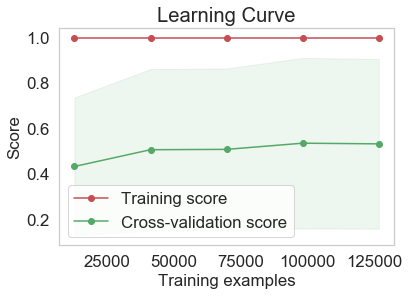

       AUC test: [0.908, 0.893, 0.863]
      AUC train: [1.0, 1.0, 1.0]
__________________________________________________
    Recall test: [0.817, 0.787, 0.726]
   Recall train: [1.0, 1.0, 1.0]
__________________________________________________
Precision test : [0.937, 0.902, 0.967]
Precision train: [1.0, 1.0, 1.0]
__________________________________________________
       F1 test : [0.873, 0.84, 0.829]
       F1 Train: [1.0, 1.0, 1.0]
[[284288     27]
 [   110    382]]
roc auc score: 86.28%


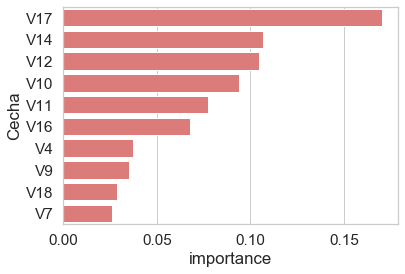

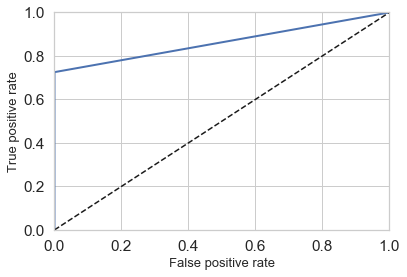

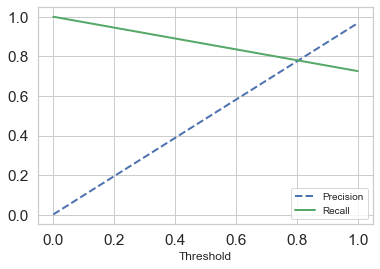

#################################################################################################
Raport
_____________________________________
Method : normal
Model : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2020,
                       verbose=0, warm_start=False)
           _  Train  Test
0        AUC    1.0  0.89
1     Recall    1.0  0.78
2  Precision    1.0  0.94
3         F1    1.0  0.85
Czas wykonania: 13 sek
Wall time: 12min 56s


In [15]:
%%time
split_and_train(RandomForestClassifier(max_depth=100, random_state=2020),method="normal",splits =3)

#################################################################################################


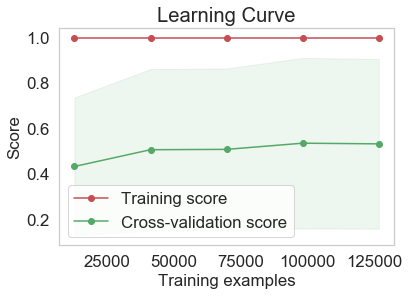

       AUC test: [0.908, 0.893, 0.863]
      AUC train: [1.0, 1.0, 1.0]
__________________________________________________
    Recall test: [0.817, 0.787, 0.726]
   Recall train: [1.0, 1.0, 1.0]
__________________________________________________
Precision test : [0.937, 0.902, 0.967]
Precision train: [1.0, 1.0, 1.0]
__________________________________________________
       F1 test : [0.873, 0.84, 0.829]
       F1 Train: [1.0, 1.0, 1.0]
[[284288     27]
 [   110    382]]
roc auc score: 86.28%


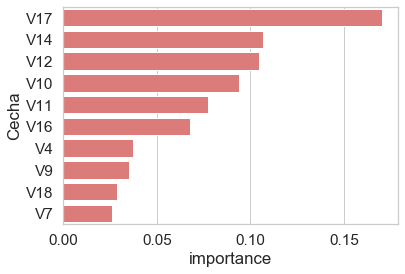

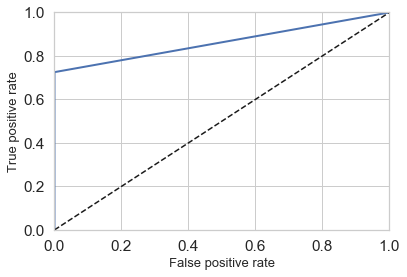

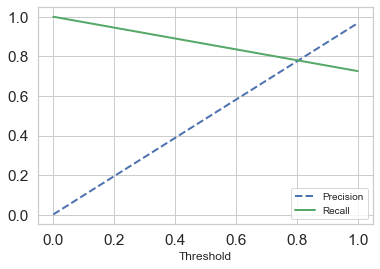

#################################################################################################
Raport
_____________________________________
Method : normal
Model : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=200, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2020,
                       verbose=0, warm_start=False)
           _  Train  Test
0        AUC    1.0  0.89
1     Recall    1.0  0.78
2  Precision    1.0  0.94
3         F1    1.0  0.85
Czas wykonania: 13 sek
Wall time: 12min 46s


In [16]:
%%time
split_and_train(RandomForestClassifier(max_depth=200, random_state=2020),method="normal",splits =3)

#################################################################################################


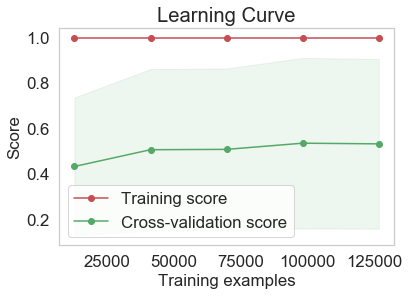

       AUC test: [0.908, 0.893, 0.863]
      AUC train: [1.0, 1.0, 1.0]
__________________________________________________
    Recall test: [0.817, 0.787, 0.726]
   Recall train: [1.0, 1.0, 1.0]
__________________________________________________
Precision test : [0.937, 0.902, 0.967]
Precision train: [1.0, 1.0, 1.0]
__________________________________________________
       F1 test : [0.873, 0.84, 0.829]
       F1 Train: [1.0, 1.0, 1.0]
[[284288     27]
 [   110    382]]
roc auc score: 86.28%


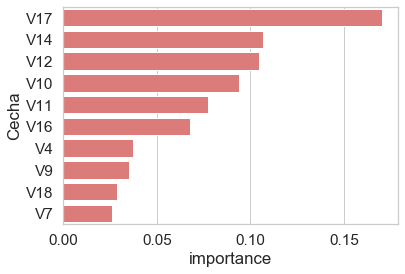

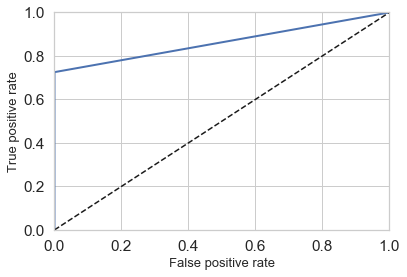

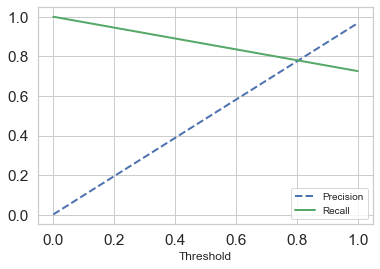

#################################################################################################
Raport
_____________________________________
Method : normal
Model : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2020,
                       verbose=0, warm_start=False)
           _  Train  Test
0        AUC    1.0  0.89
1     Recall    1.0  0.78
2  Precision    1.0  0.94
3         F1    1.0  0.85
Czas wykonania: 13 sek
Wall time: 12min 44s


In [17]:
%%time
split_and_train(RandomForestClassifier(max_depth=500, random_state=2020),method="normal",splits =3)

# Random Forest undersampling

#################################################################################################
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})


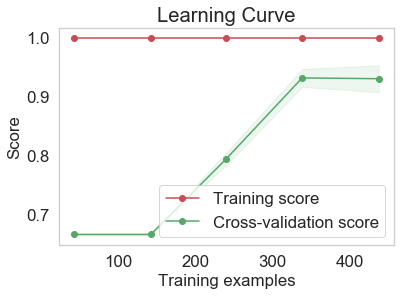

      AUC: [0.941, 0.953, 0.928]
   Recall: [0.902, 0.921, 0.872]
Precision: [0.073, 0.095, 0.09]
       F1: [0.135, 0.172, 0.163]
[[279535   4780]
 [    50    442]]
roc auc score: 92.83%


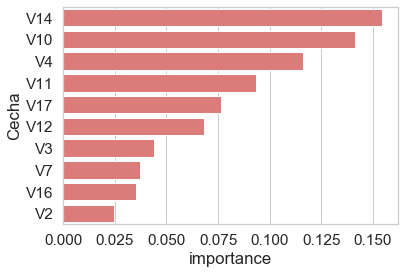

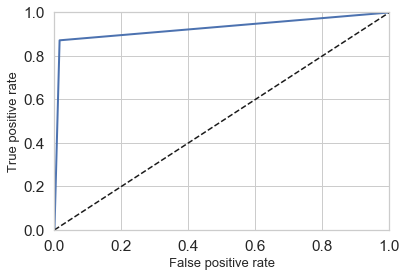

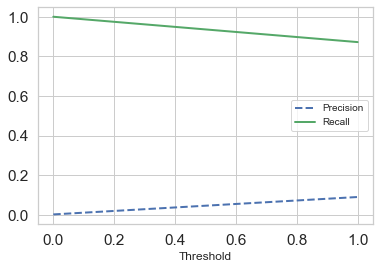

#################################################################################################
Raport
_____________________________________
Method : undersampling
Model : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2020,
                       verbose=0, warm_start=False)
           _  Train  Test
0        AUC    1.0  0.94
1     Recall    1.0  0.90
2  Precision    1.0  0.09
3         F1    1.0  0.16
Czas wykonania: 0 sek
Wall time: 4.78 s


In [18]:
%%time
split_and_train(RandomForestClassifier(max_depth=50, random_state=2020),method="undersampling",splits =3)

#################################################################################################
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})


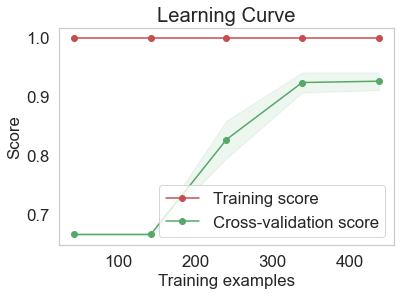

      AUC: [0.941, 0.951, 0.931]
   Recall: [0.915, 0.927, 0.878]
Precision: [0.046, 0.061, 0.091]
       F1: [0.087, 0.114, 0.165]
[[277380   6935]
 [    46    446]]
roc auc score: 93.14%


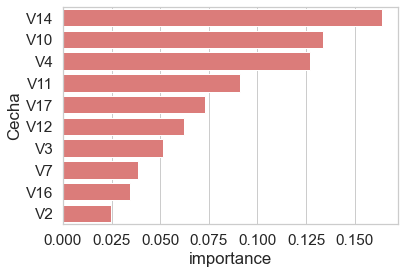

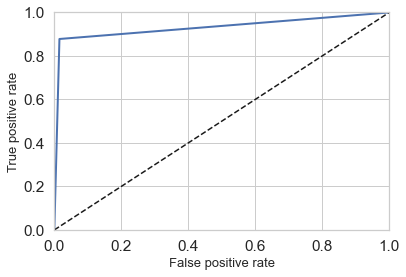

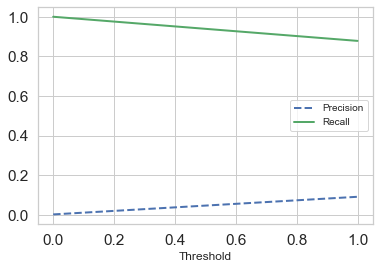

#################################################################################################
Raport
_____________________________________
Method : undersampling
Model : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2020,
                       verbose=0, warm_start=False)
           _  Train  Test
0        AUC    1.0  0.94
1     Recall    1.0  0.91
2  Precision    1.0  0.07
3         F1    1.0  0.12
Czas wykonania: 0 sek
Wall time: 6.42 s


In [43]:
%%time
split_and_train(RandomForestClassifier(max_depth=100, random_state=2020),method="undersampling",splits =3)

#################################################################################################
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})


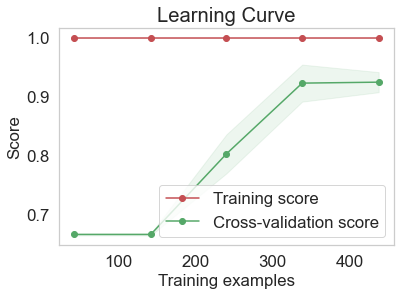

      AUC: [0.938, 0.945, 0.926]
   Recall: [0.909, 0.927, 0.872]
Precision: [0.047, 0.042, 0.068]
       F1: [0.09, 0.081, 0.127]
[[275924   8391]
 [    48    444]]
roc auc score: 92.57%


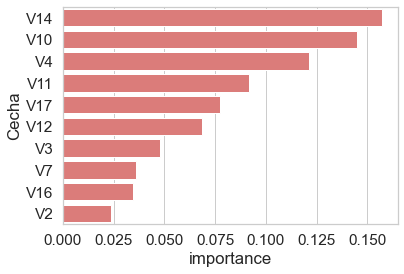

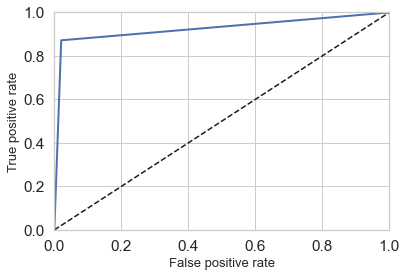

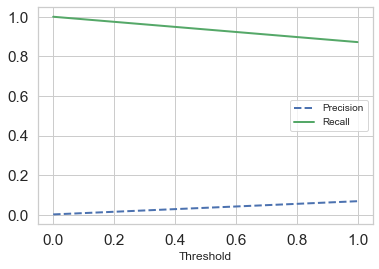

#################################################################################################
Raport
_____________________________________
Method : undersampling
Model : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=300, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2020,
                       verbose=0, warm_start=False)
           _  Train  Test
0        AUC    1.0  0.94
1     Recall    1.0  0.90
2  Precision    1.0  0.05
3         F1    1.0  0.10
Czas wykonania: 0 sek
Wall time: 6.55 s


In [44]:
%%time
split_and_train(RandomForestClassifier(max_depth=300, random_state=2020),method="undersampling",splits =3)

#################################################################################################
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})


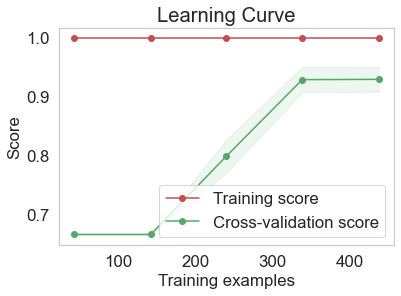

      AUC: [0.943, 0.952, 0.933]
   Recall: [0.902, 0.927, 0.884]
Precision: [0.088, 0.068, 0.075]
       F1: [0.16, 0.127, 0.139]
[[278909   5406]
 [    47    445]]
roc auc score: 93.27%


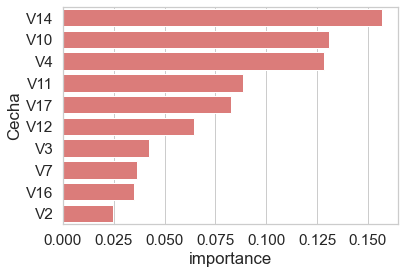

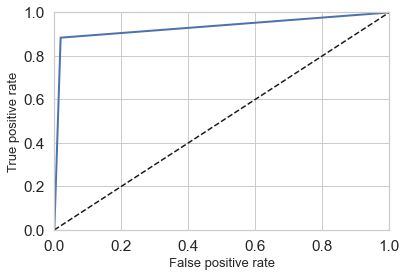

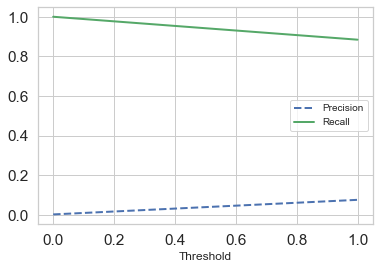

#################################################################################################
Raport
_____________________________________
Method : undersampling
Model : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2020,
                       verbose=0, warm_start=False)
           _  Train  Test
0        AUC    1.0  0.94
1     Recall    1.0  0.90
2  Precision    1.0  0.08
3         F1    1.0  0.14
Czas wykonania: 0 sek
Wall time: 7.34 s


In [45]:
%%time
split_and_train(RandomForestClassifier(max_depth=500, random_state=2020),method="undersampling",splits =3)

# Random Forest Oversampling

#################################################################################################
Counter({0: 189543, 1: 189543})
Counter({0: 94775, 1: 161})
Counter({0: 189543, 1: 189543})
Counter({0: 94775, 1: 161})
Counter({0: 189544, 1: 189544})
Counter({0: 94794, 1: 141})


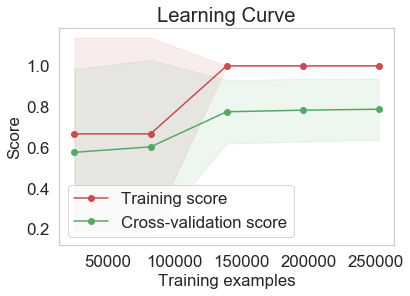

      AUC: [0.918, 0.921, 0.896]
   Recall: [0.835, 0.841, 0.793]
Precision: [0.851, 0.857, 0.922]
       F1: [0.843, 0.849, 0.852]
[[284257     58]
 [    87    405]]
roc auc score: 89.63%


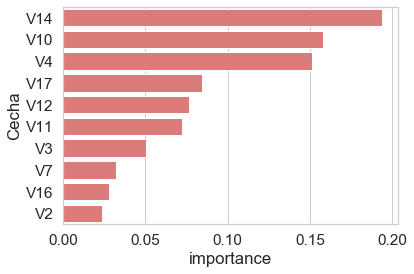

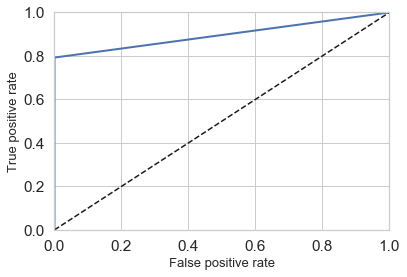

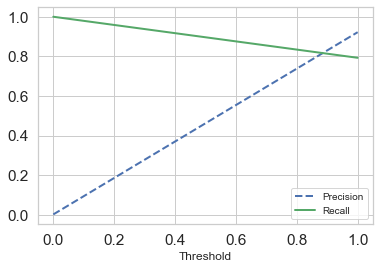

#################################################################################################
Raport
_____________________________________
Method : oversampling
Model : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2020,
                       verbose=0, warm_start=False)
           _  Train  Test
0        AUC    1.0  0.91
1     Recall    1.0  0.82
2  Precision    1.0  0.88
3         F1    1.0  0.85
Czas wykonania: 26 sek
Wall time: 26min 4s


In [21]:
%%time
split_and_train(RandomForestClassifier(max_depth=50, random_state=2020),method="oversampling",splits =3)

#################################################################################################
Counter({0: 189543, 1: 189543})
Counter({0: 94775, 1: 161})
Counter({0: 189543, 1: 189543})
Counter({0: 94775, 1: 161})
Counter({0: 189544, 1: 189544})
Counter({0: 94794, 1: 141})


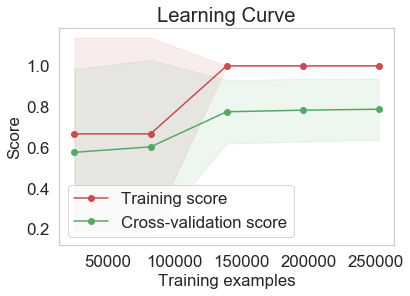

      AUC: [0.918, 0.921, 0.896]
   Recall: [0.835, 0.841, 0.793]
Precision: [0.851, 0.857, 0.922]
       F1: [0.843, 0.849, 0.852]
[[284257     58]
 [    87    405]]
roc auc score: 89.63%


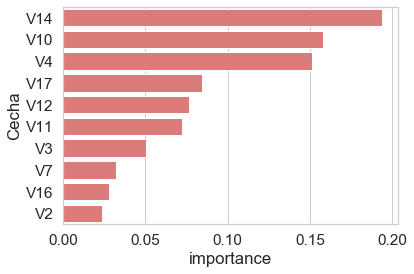

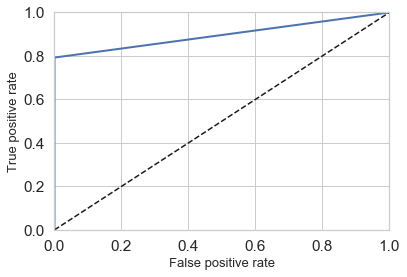

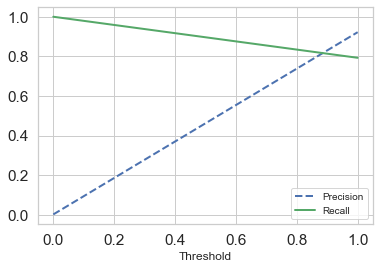

#################################################################################################
Raport
_____________________________________
Method : oversampling
Model : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2020,
                       verbose=0, warm_start=False)
           _  Train  Test
0        AUC    1.0  0.91
1     Recall    1.0  0.82
2  Precision    1.0  0.88
3         F1    1.0  0.85
Czas wykonania: 27 sek
Wall time: 27min 28s


In [22]:
%%time
split_and_train(RandomForestClassifier(max_depth=100, random_state=2020),method="oversampling",splits =3)

#################################################################################################
Counter({0: 189543, 1: 189543})
Counter({0: 94775, 1: 161})
Counter({0: 189543, 1: 189543})
Counter({0: 94775, 1: 161})
Counter({0: 189544, 1: 189544})
Counter({0: 94794, 1: 141})


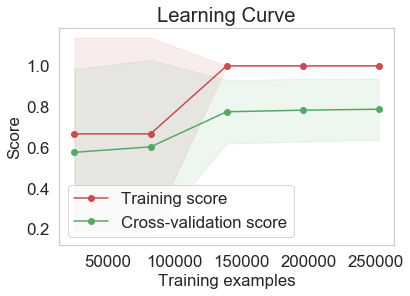

      AUC: [0.918, 0.921, 0.896]
   Recall: [0.835, 0.841, 0.793]
Precision: [0.851, 0.857, 0.922]
       F1: [0.843, 0.849, 0.852]
[[284257     58]
 [    87    405]]
roc auc score: 89.63%


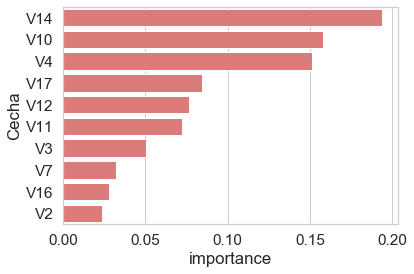

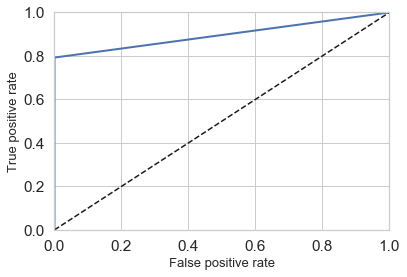

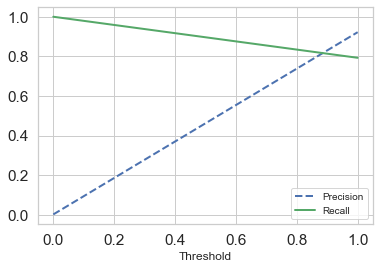

#################################################################################################
Raport
_____________________________________
Method : oversampling
Model : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=300, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2020,
                       verbose=0, warm_start=False)
           _  Train  Test
0        AUC    1.0  0.91
1     Recall    1.0  0.82
2  Precision    1.0  0.88
3         F1    1.0  0.85
Czas wykonania: 26 sek
Wall time: 26min 5s


In [23]:
%%time
split_and_train(RandomForestClassifier(max_depth=300, random_state=2020),method="oversampling",splits =3)

#################################################################################################
Counter({0: 189543, 1: 189543})
Counter({0: 94775, 1: 161})
Counter({0: 189543, 1: 189543})
Counter({0: 94775, 1: 161})
Counter({0: 189544, 1: 189544})
Counter({0: 94794, 1: 141})


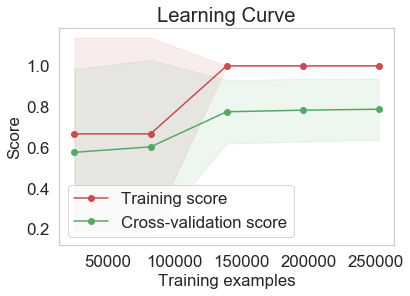

      AUC: [0.918, 0.921, 0.896]
   Recall: [0.835, 0.841, 0.793]
Precision: [0.851, 0.857, 0.922]
       F1: [0.843, 0.849, 0.852]
[[284257     58]
 [    87    405]]
roc auc score: 89.63%


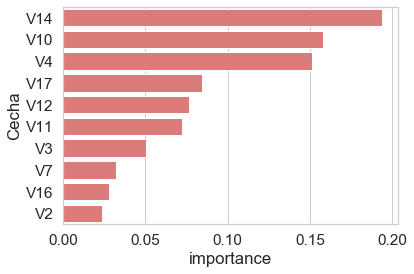

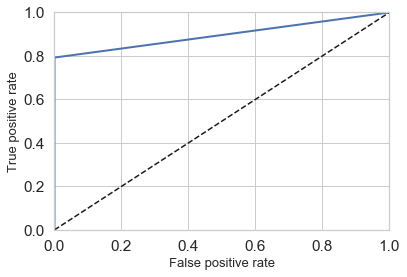

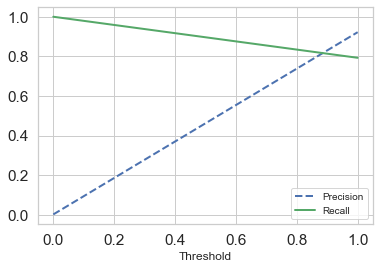

#################################################################################################
Raport
_____________________________________
Method : oversampling
Model : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2020,
                       verbose=0, warm_start=False)
           _  Train  Test
0        AUC    1.0  0.91
1     Recall    1.0  0.82
2  Precision    1.0  0.88
3         F1    1.0  0.85
Czas wykonania: 26 sek
Wall time: 25min 56s


In [24]:
%%time
split_and_train(RandomForestClassifier(max_depth=500, random_state=2020),method="oversampling",splits =3)

# XGBoost normal 

#################################################################################################


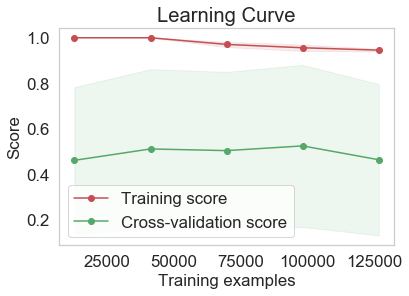

       AUC test: [0.905, 0.902, 0.857]
      AUC train: [0.916, 0.916, 0.934]
__________________________________________________
    Recall test: [0.811, 0.805, 0.713]
   Recall train: [0.832, 0.832, 0.869]
__________________________________________________
Precision test : [0.917, 0.904, 0.975]
Precision train: [0.978, 0.989, 0.986]
__________________________________________________
       F1 test : [0.861, 0.852, 0.824]
       F1 Train: [0.9, 0.904, 0.924]
[[284286     29]
 [   110    382]]
roc auc score: 85.67%


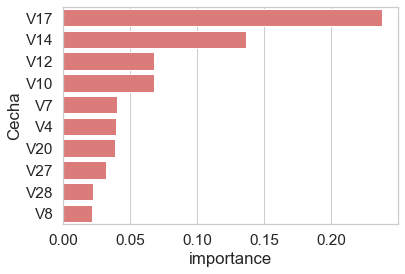

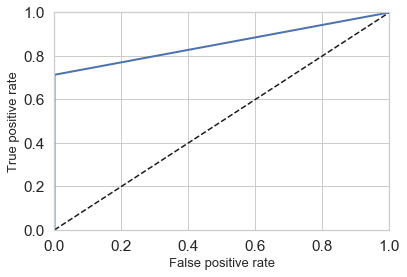

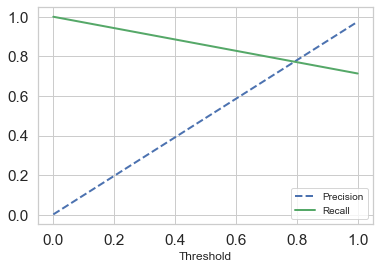

#################################################################################################
Raport
_____________________________________
Method : normal
Model : XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=2020, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
           _  Train  Test
0        AUC   0.92  0.89
1     Recall   0.84  0.78
2  Precision   0.98  0.93
3         F1   0.91  0.85
Czas wykonania: 1 sek
Wall time: 1min 11s


In [25]:
%%time
split_and_train(xgb.XGBClassifier(max_depth=2, random_state=2020),method="normal",splits =3)

#################################################################################################


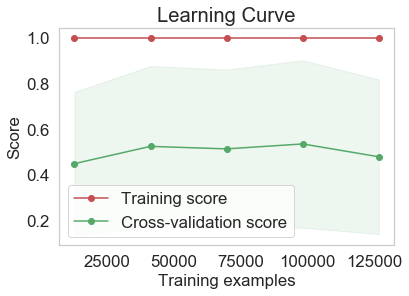

       AUC test: [0.918, 0.905, 0.863]
      AUC train: [0.974, 0.979, 0.988]
__________________________________________________
    Recall test: [0.835, 0.811, 0.726]
   Recall train: [0.948, 0.957, 0.976]
__________________________________________________
Precision test : [0.945, 0.905, 0.983]
Precision train: [1.0, 1.0, 1.0]
__________________________________________________
       F1 test : [0.887, 0.855, 0.835]
       F1 Train: [0.973, 0.978, 0.988]
[[284291     24]
 [   103    389]]
roc auc score: 86.28%


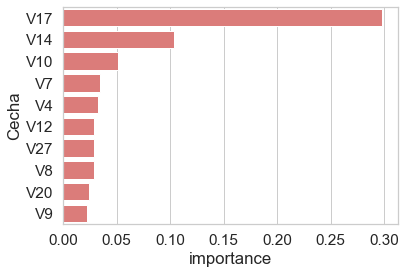

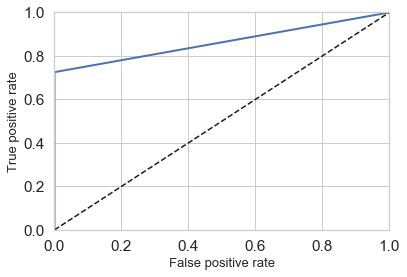

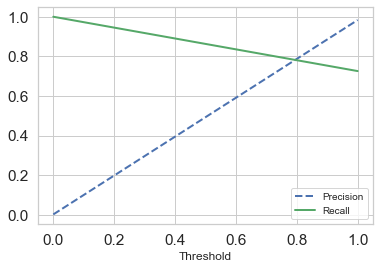

#################################################################################################
Raport
_____________________________________
Method : normal
Model : XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=2020, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
           _  Train  Test
0        AUC   0.98  0.90
1     Recall   0.96  0.79
2  Precision   1.00  0.94
3         F1   0.98  0.86
Czas wykonania: 2 sek
Wall time: 1min 31s


In [27]:
%%time
split_and_train(xgb.XGBClassifier(max_depth=3, random_state=2020),method="normal",splits =3)

#################################################################################################


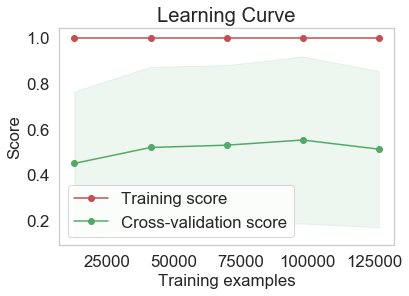

       AUC test: [0.915, 0.905, 0.863]
      AUC train: [1.0, 1.0, 1.0]
__________________________________________________
    Recall test: [0.829, 0.811, 0.726]
   Recall train: [1.0, 1.0, 1.0]
__________________________________________________
Precision test : [0.938, 0.905, 0.983]
Precision train: [1.0, 1.0, 1.0]
__________________________________________________
       F1 test : [0.88, 0.855, 0.835]
       F1 Train: [1.0, 1.0, 1.0]
[[284290     25]
 [   104    388]]
roc auc score: 86.28%


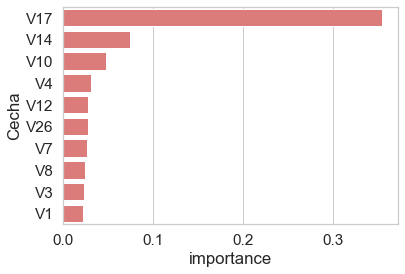

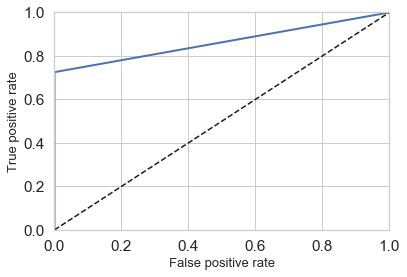

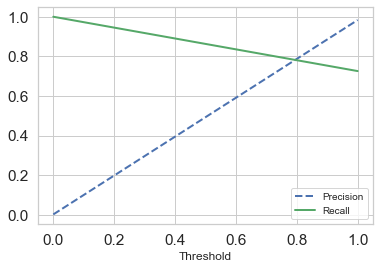

#################################################################################################
Raport
_____________________________________
Method : normal
Model : XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=2020, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
           _  Train  Test
0        AUC    1.0  0.89
1     Recall    1.0  0.79
2  Precision    1.0  0.94
3         F1    1.0  0.86
Czas wykonania: 2 sek
Wall time: 2min 5s


In [28]:
%%time
split_and_train(xgb.XGBClassifier(max_depth=5, random_state=2020),method="normal",splits =3)

# XGBoost undersampling

#################################################################################################
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})


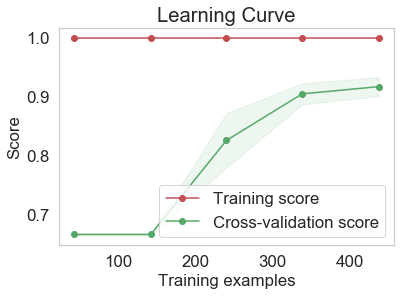

      AUC: [0.95, 0.947, 0.928]
   Recall: [0.939, 0.933, 0.89]
Precision: [0.04, 0.04, 0.044]
       F1: [0.077, 0.076, 0.084]
[[273789  10526]
 [    39    453]]
roc auc score: 92.84%


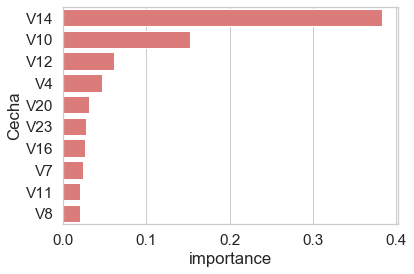

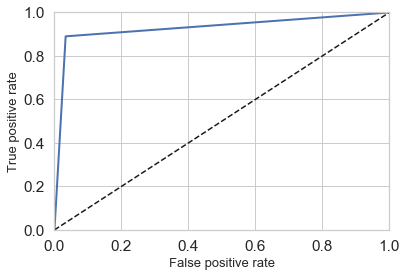

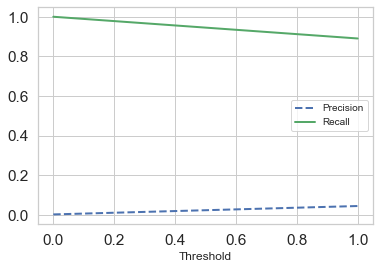

#################################################################################################
Raport
_____________________________________
Method : undersampling
Model : XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=2020, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
           _  Train  Test
0        AUC    1.0  0.94
1     Recall    1.0  0.92
2  Precision    1.0  0.04
3         F1    1.0  0.08
Czas wykonania: 0 sek
Wall time: 2.23 s


In [29]:
%%time
split_and_train(xgb.XGBClassifier(max_depth=2, random_state=2020),method="undersampling",splits =3)

#################################################################################################
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})


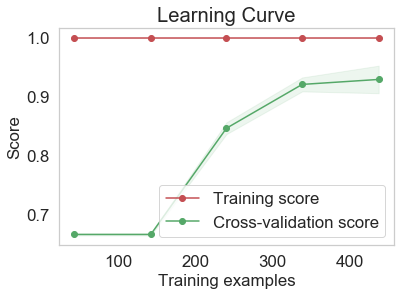

      AUC: [0.943, 0.944, 0.933]
   Recall: [0.927, 0.927, 0.902]
Precision: [0.037, 0.04, 0.042]
       F1: [0.071, 0.076, 0.08]
[[273302  11013]
 [    40    452]]
roc auc score: 93.33%


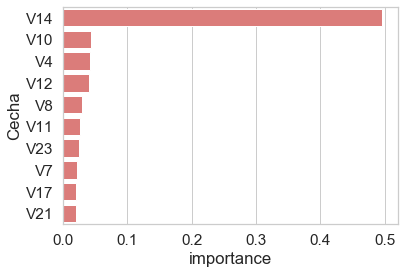

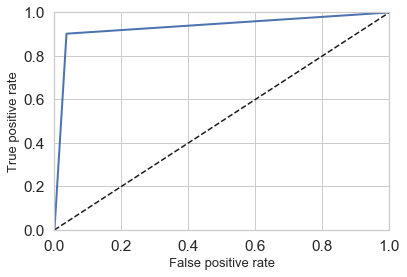

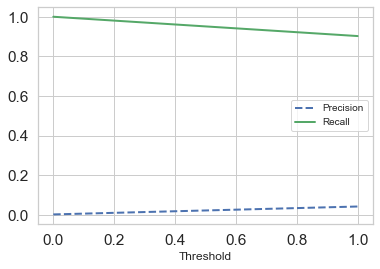

#################################################################################################
Raport
_____________________________________
Method : undersampling
Model : XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=2020, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
           _  Train  Test
0        AUC    1.0  0.94
1     Recall    1.0  0.92
2  Precision    1.0  0.04
3         F1    1.0  0.08
Czas wykonania: 0 sek
Wall time: 2.24 s


In [30]:
%%time
split_and_train(xgb.XGBClassifier(max_depth=3, random_state=2020),method="undersampling",splits =3)

#################################################################################################
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})
Counter({1: 328, 0: 328})


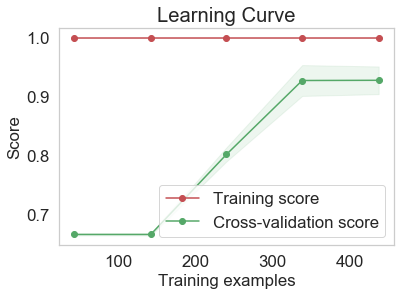

      AUC: [0.945, 0.947, 0.934]
   Recall: [0.921, 0.939, 0.909]
Precision: [0.051, 0.034, 0.037]
       F1: [0.096, 0.066, 0.071]
[[273287  11028]
 [    38    454]]
roc auc score: 93.38%


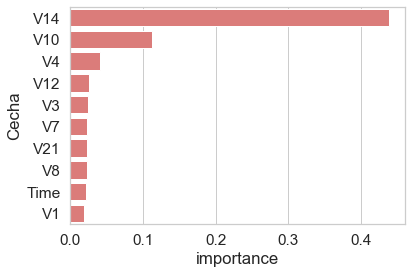

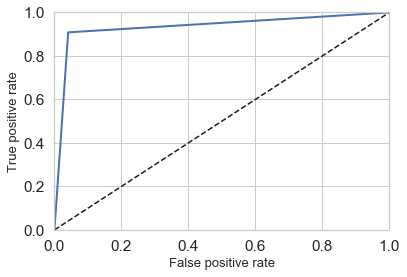

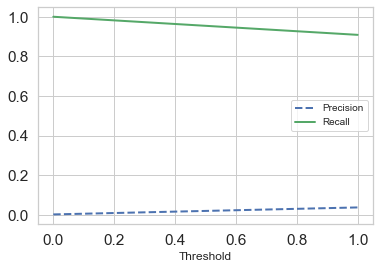

#################################################################################################
Raport
_____________________________________
Method : undersampling
Model : XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=2020, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
           _  Train  Test
0        AUC    1.0  0.94
1     Recall    1.0  0.92
2  Precision    1.0  0.04
3         F1    1.0  0.08
Czas wykonania: 0 sek
Wall time: 2.31 s


In [31]:
%%time
split_and_train(xgb.XGBClassifier(max_depth=5, random_state=2020),method="undersampling",splits =3)

# XGBoost oversampling

#################################################################################################
Counter({0: 189543, 1: 189543})
Counter({0: 94361, 1: 575})
Counter({0: 189543, 1: 189543})
Counter({0: 94420, 1: 516})
Counter({0: 189544, 1: 189544})
Counter({0: 94477, 1: 458})


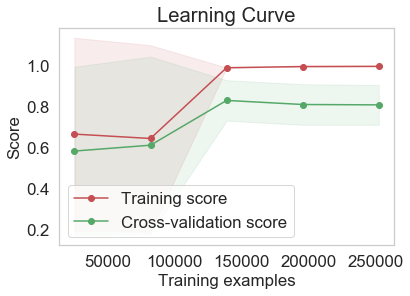

      AUC: [0.94, 0.931, 0.913]
   Recall: [0.884, 0.866, 0.829]
Precision: [0.252, 0.275, 0.297]
       F1: [0.392, 0.418, 0.437]
[[283189   1126]
 [    69    423]]
roc auc score: 91.29%


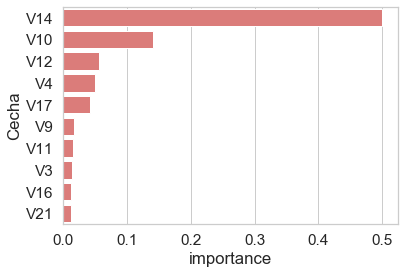

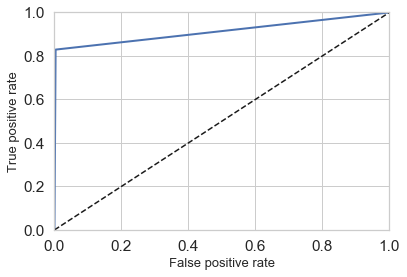

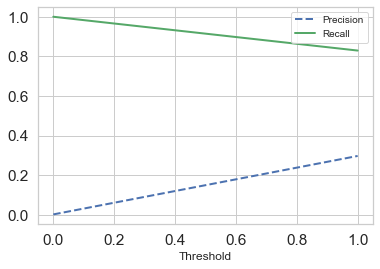

#################################################################################################
Raport
_____________________________________
Method : oversampling
Model : XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=2020, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
           _  Train  Test
0        AUC   1.00  0.93
1     Recall   0.99  0.86
2  Precision   1.00  0.27
3         F1   1.00  0.42
Czas wykonania: 2 sek
Wall time: 2min 30s


In [32]:
%%time
split_and_train(xgb.XGBClassifier(max_depth=2, random_state=2020),method="oversampling",splits =3)

#################################################################################################
Counter({0: 189543, 1: 189543})
Counter({0: 94625, 1: 311})
Counter({0: 189543, 1: 189543})
Counter({0: 94627, 1: 309})
Counter({0: 189544, 1: 189544})
Counter({0: 94692, 1: 243})


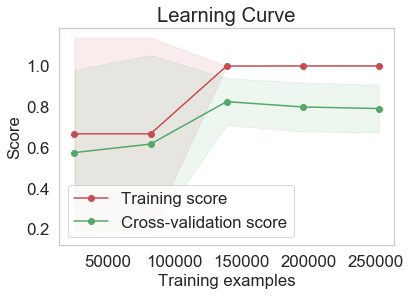

      AUC: [0.938, 0.935, 0.911]
   Recall: [0.878, 0.872, 0.823]
Precision: [0.463, 0.463, 0.556]
       F1: [0.606, 0.605, 0.663]
[[283874    441]
 [    70    422]]
roc auc score: 91.1%


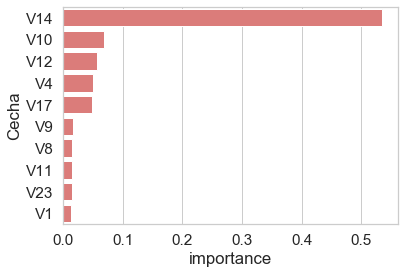

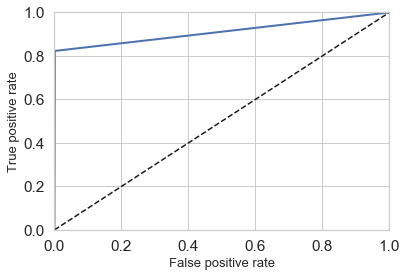

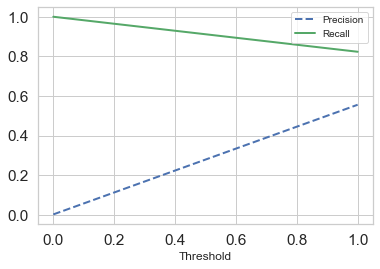

#################################################################################################
Raport
_____________________________________
Method : oversampling
Model : XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=2020, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
           _  Train  Test
0        AUC    1.0  0.93
1     Recall    1.0  0.86
2  Precision    1.0  0.49
3         F1    1.0  0.62
Czas wykonania: 3 sek
Wall time: 2min 50s


In [33]:
%%time
split_and_train(xgb.XGBClassifier(max_depth=3, random_state=2020),method="oversampling",splits =3)

#################################################################################################
Counter({0: 189543, 1: 189543})
Counter({0: 94751, 1: 185})
Counter({0: 189543, 1: 189543})
Counter({0: 94754, 1: 182})
Counter({0: 189544, 1: 189544})
Counter({0: 94783, 1: 152})


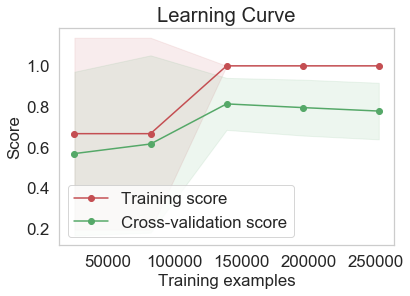

      AUC: [0.939, 0.93, 0.902]
   Recall: [0.878, 0.86, 0.805]
Precision: [0.778, 0.775, 0.868]
       F1: [0.825, 0.815, 0.835]
[[284213    102]
 [    75    417]]
roc auc score: 90.23%


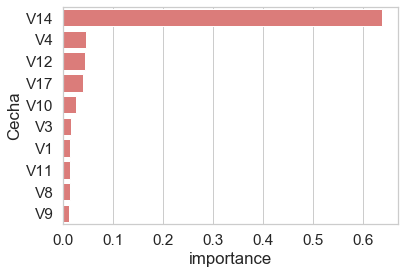

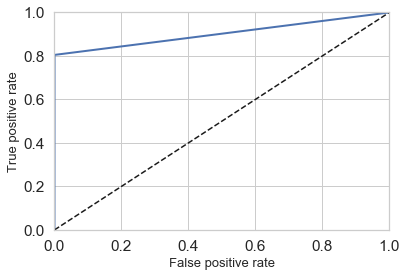

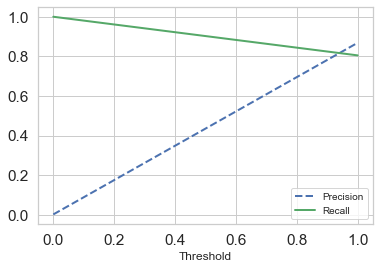

#################################################################################################
Raport
_____________________________________
Method : oversampling
Model : XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=2020, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
           _  Train  Test
0        AUC    1.0  0.92
1     Recall    1.0  0.85
2  Precision    1.0  0.81
3         F1    1.0  0.82
Czas wykonania: 4 sek
Wall time: 4min 18s


In [34]:
%%time
split_and_train(xgb.XGBClassifier(max_depth=5, random_state=2020),method="oversampling",splits =3)

# Hyperopt

In [103]:
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [104]:
X = df.loc[:, df.columns!='Class']
y = df.loc[:,'Class']

# The best results achieve XGBoost with normal method. Lets try optimize hyperparameters using Hyperopt

# XGB normal

In [345]:
%%time

# 'max_depth': int(space['max_depth']),
# 'max_depth': hp.quniform ('max_depth', 1, 20, 1),
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'random_state': int(space['random_state']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'n_estimators': int(space['n_estimators']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'objective': 'reg:squarederror'
    }   
    
    
    scores_f = []
    scores_f_train = []
    scores = []
    
####################################################################
    
    cv = StratifiedKFold(n_splits=3, random_state=2020, shuffle=True)
    for train_idx, test_idx in cv.split(X, y):
        
        model = xgb.XGBClassifier(**xgb_params)
        model.fit(X.loc[train_idx], y.loc[train_idx])
        y_pred = model.predict(X.loc[test_idx])
        y_pred_train = model.predict(X.loc[train_idx])
            
            
        X_tr = X.loc[train_idx]
        y_tr = y.loc[train_idx]
        X_t = X.loc[test_idx]
        y_t = y.loc[test_idx]

        score = round(f1_score(y_t, y_pred),3)
        score_train = round(f1_score(y_tr, y_pred_train),3)

        scores_f.append(score)
        scores_f_train.append(score_train)

    scores = np.mean(scores_f)
    scores_f_train = np.mean(scores_f_train)
    print("####################################################################")
    print("Train:{}::: Test:{}".format(scores_f_train,scores))
    print(model)
    
    #score = ((scores_f_train - scores) * (1 - scores)) + (1-scores)
    score = 1-scores
####################################################################
    
    print("SCORE: {0}".format(score))
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 1, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.1, 1.),
    'n_estimators': hp.quniform ('x_n_estimators', 0, 1000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 0, 1, 0.1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.1, 1.),
    'random_state': 2020
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=5),
            max_evals=50,
            trials=trials)

print("The best params: ", best_params)

####################################################################                                                   
Train:0.9806666666666667::: Test:0.8526666666666666                                                                    
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,                                                       
              colsample_bynode=1, colsample_bytree=0.9452503604039603, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.08206626897416991, max_delta_step=0, max_depth=15,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=450, n_jobs=0, num_parallel_tree=1,
              objective='reg:squarederror', random_state=2020,
              reg_alpha=2.1774725249416997, reg_lambda=0.8491933408955106,
              scale_pos_weight=1, subsample=0.9514188656029782,
              tree_method=None, validate_parameters=False, ve

              tree_method=None, validate_parameters=False, verbosity=None)
SCORE: 0.1469999999999999                                                                                              
####################################################################                                                   
Train:0.9756666666666666::: Test:0.8546666666666667                                                                    
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,                                                       
              colsample_bynode=1, colsample_bytree=0.8664204551300598, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.11194028922114628, max_delta_step=0, max_depth=18,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='reg:squarederror', random_state=2020,
     

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,                                                       
              colsample_bynode=1, colsample_bytree=0.9469111461169376, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.15551418135938636, max_delta_step=0, max_depth=4,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=950, n_jobs=0, num_parallel_tree=1,
              objective='reg:squarederror', random_state=2020,
              reg_alpha=1.7738730565613434, reg_lambda=0.5196031136718353,
              scale_pos_weight=1, subsample=0.37509890834110066,
              tree_method=None, validate_parameters=False, verbosity=None)
SCORE: 0.14200000000000002                                                                                             
####################################################################                                      

              tree_method=None, validate_parameters=False, verbosity=None)
SCORE: 0.15300000000000002                                                                                             
####################################################################                                                   
Train:0.7433333333333333::: Test:0.73                                                                                  
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,                                                       
              colsample_bynode=1, colsample_bytree=0.9686844657362057, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1288527496913787, max_delta_step=0, max_depth=1,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=0, num_parallel_tree=1,
              objective='reg:squarederror', random_state=2020,
        

#################################################################################################


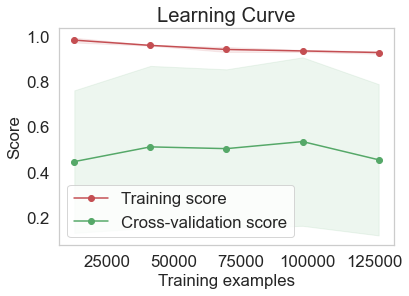

       AUC test: [0.908, 0.899, 0.866]
      AUC train: [0.915, 0.912, 0.933]
__________________________________________________
    Recall test: [0.817, 0.799, 0.732]
   Recall train: [0.829, 0.823, 0.866]
__________________________________________________
Precision test : [0.918, 0.885, 0.96]
Precision train: [0.975, 0.985, 0.966]
__________________________________________________
       F1 test : [0.865, 0.84, 0.83]
       F1 Train: [0.896, 0.897, 0.913]
[[284281     34]
 [   107    385]]
roc auc score: 86.58%


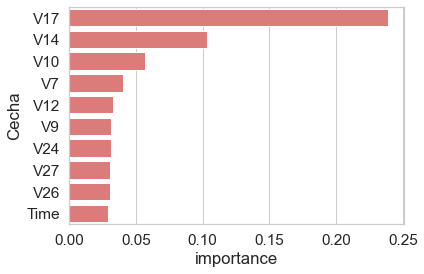

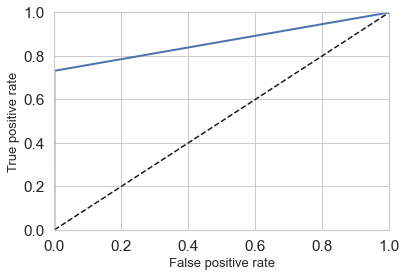

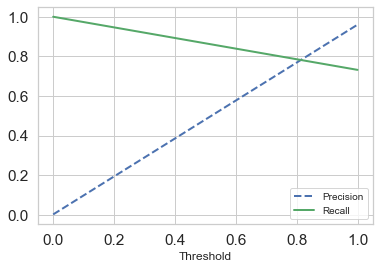

#################################################################################################
Raport
_____________________________________
Method : normal
Model : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1,
              x_colsample_bytree=0.9748555743775745,
              x_learning_rate=0.11695862476807858, x_max_depth=3,
              x_min_child_weight=0.6000000000000001, x_n_estimators=450,
              x_reg_alpha=1.4013693308061304, x_reg_lambda=0.155587283, ...)
           _  Train  Test
0        AUC   0.92  0.89
1     Recall   0.84  0.78
2  Precision   0

In [22]:
best_params =   {'x_colsample_bytree': 0.9748555743775745,
                 'x_learning_rate': 0.11695862476807858,
                 'x_max_depth': 3,
                 'x_min_child_weight': 0.6000000000000001,
                 'x_n_estimators':450,
                 'x_reg_alpha': 1.4013693308061304,
                 'x_reg_lambda': 0.155587283,
                 'x_subsample': 0.5325400883643572}

split_and_train(xgb.XGBClassifier(**best_params),method="normal",splits =3)


# Final results 

XGBoost: F1_score

Train: 0.90
Test: 0.85